# Synthesizing Benchmarks for Predictive Modeling

[Chris Cummins](http://chriscummins.cc/),
[Pavlos Petoumenos](http://homepages.inf.ed.ac.uk/ppetoume/),
[Zheng Wang](http://www.lancaster.ac.uk/staff/wangz3/),
[Hugh Leather](http://homepages.inf.ed.ac.uk/hleather/).

**Abstract**
> Predictive modeling using machine learning is an effective method for building
> compiler heuristics, but there is a shortage of benchmarks. Typical machine
> learning experiments outside of the compilation field train over thousands or
> millions of examples. In machine learning for compilers, however, there are
> typically only a few dozen common benchmarks available. This limits the
> quality of learned models, as they have very sparse training data for what are
> often high-dimensional feature spaces. What is needed is a way to generate an
> unbounded number of training programs that finely cover the feature space. At
> the same time the generated programs must be similar to the types of programs
> that human developers actually write, otherwise the learning will target the
> wrong parts of the feature space.
>
> We mine open source repositories for program fragments and apply deep learning
> techniques to automatically construct models for how humans write programs. We
> then sample the models to generate an unbounded number of runnable training
> programs, covering the feature space ever more finely. The quality of the
> programs is such that even human developers struggle to distinguish our
> generated programs from hand-written code.
>
> We use our generator for OpenCL programs, CLgen, to automatically synthesize
> thousands of programs and show that learning over these improves the
> performance of a state of the art predictive model by $1.27\times$. In
> addition, the fine covering of the feature space automatically exposes
> weaknesses in the feature design which are invisible with the sparse training
> examples from existing benchmark suites. Correcting these weaknesses further
> increases performance by $4.30\times$.

**Keywords**  Synthetic program generation, OpenCL, Benchmarking, Deep Learning, GPUs

This is a live research artifact. See [here](https://github.com/ChrisCummins/paper-synthesizing-benchmarks) for instructions to install this artifact on your own hardware. Please note that performance numbers obtained on hardware different to what we used may differ from those in the paper.

In [1]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run lib/preamble.py

from IPython.core.display import HTML
HTML("""<style>
/* hide index column in Pandas Data Frames */
table.dataframe thead th:first-child { display: none; }
table.dataframe tbody th { display: none; }

/* tweak text size */
div.text_cell_render { font-size: 1.3em; line-height: 1.4em; }
</style>""")

         There may be incompatabilities.


# 1. Introduction

Predictive modeling is a well researched method for building optimization
heuristics that often exceed human experts and reduces development time. A set
of training programs are identified which are expected to be representative of
the application domain. The programs are compiled and executed with different
parameter values for the target heuristic, to determine which are the best
values for each training program. Each program is also summarized by a vector of
features which describe the information that is expected to be important in
predicting the best heuristic parameter values. These training examples of
program features and desired heuristic values are used to create a machine
learning model which, when given the features from a new, unseen program, can
predict good heuristic values for it.

It is common for the feature vectors to contain dozens of elements. This means
that a large volume of training data is needed to have an adequate sampling over
the feature space. Without it, the machine learned models can only capture the
coarse characteristics of the heuristic, and new programs which do not lie near
to training points may be wrongly predicted. The accuracy of the machine learned
heuristic is thus limited by the sparsity of the training points.

There have been efforts to solve this problem using templates. The essence of
the approach is to construct a probabilistic grammar with embedded semantic
actions that defines a language of possible programs. New programs may be
created by sampling the grammar and, through setting probabilities on the
grammar productions, the sampling is biased towards producing programs from one
part of the space or another. This technique is potentially completely general,
since a grammar can theoretically be constructed to match any desired program
domain. However, despite being theoretically possible, it is not easy to
construct grammars which are both suitably general and also produce programs
that are in any way similar to human written programs. It has been shown to be
successful over a highly restricted space of stencil benchmarks with little
control flow or program variability. But, it is not clear how much effort it
will take, or even if it is possible for human experts to define grammars
capable of producing human like programs in more complex domains.

By contrast, our approach does not require an expert to define what human
programs look like. Instead, we automatically infer the structure and likelihood
of programs over a huge corpus of open source projects. From this corpus, we
learn a probability distribution over sets of characters seen in human written
code. Later, we sample from this distribution to generate new random programs
which, because the distribution models human written code, are indistinguishable
from human code. We can then populate our training data with an unbounded number
of human like programs, covering the space with any desired granularity, far
more finely than either existing benchmark suites, or even the corpus of open
source projects. Our approach is enabled by two recent developments:

The first is the breakthrough effectiveness of deep learning for modeling
complex structure in natural languages. As we show, deep learning is capable not
just of learning the macro syntactical and semantic structure of programs, but
also the nuances of how humans typically write code. It is truly remarkable when
one considers that it is given no prior knowledge of the syntax or semantics of
the language.

The second is the increasing popularity of public and open platforms for hosting
software projects and source code. This popularity furnishes us with the
thousands of programming examples that are necessary to feed into the deep
learning. These open source examples are not, sadly, as useful for directly
learning the compiler heuristics since they are not presented in a uniform,
runnable manner, nor do they typically have extractable test data. Preparing
each of the thousands of open source projects to be directly applicable for
learning compiler heuristics would be an insurmountable task. In addition to our
program generator, CLgen, we also provide an accompanying host driver which
generates datasets for, then executes and profiles synthesized programs.

We make the following contributions:

-   We are the first to apply deep learning over source codes to
    synthesize compilable, executable benchmarks.

-   A novel tool CLgen for general-purpose benchmark synthesis using
    deep learning. CLgen automatically generates thousands of human like
    programs for use in predictive modeling.

-   We use CLgen to automatically improve the performance of a state of
    the art predictive model by 1.27x, and expose limitations in
    the feature design of the model which, after correcting, further
    increases performance by 2.66x.

# 2. Motivation

In this section we make the argument for synthetic benchmarks. We identified
frequently used benchmark suites in a survey of research papers in the field
of GPGPU performance tuning from top tier conferences between 2013–2016: CGO,
HiPC, PACT, and PPoPP:

In [2]:
data = pd.read_csv("../data/lit-review.csv")
data

,Conference,Year,Paper,Benchmark Suite
0,HiPC,2015,paper-01,NVIDIA SDK
1,HiPC,2015,paper-01,NVIDIA SDK
2,HiPC,2015,paper-01,NVIDIA SDK
3,HiPC,2015,paper-01,NVIDIA SDK
4,HiPC,2015,paper-01,NVIDIA SDK
5,HiPC,2015,paper-01,NVIDIA SDK
6,HiPC,2015,paper-01,NVIDIA SDK
...,...,...,...,...
441,PPoPP,2013,paper-26,Rodinia
442,PPoPP,2013,paper-26,Rodinia


Analysis of results:

In [3]:
benchmark_counts = [x[1] for x in data.groupby("Paper").size().iteritems()]
suites = pd.DataFrame(
    [(x[0], x[1] / labmath.mean(benchmark_counts))
     for x in data.groupby(["Benchmark Suite"]).size().iteritems()],
    columns=["Benchmark Suite", "#. benchmarks per paper"])
suites.sort_values("#. benchmarks per paper", inplace=True, ascending=False)

print("Average number of benchmarks per paper:", round(labmath.mean(benchmark_counts), 2))
print("Median number of benchmarks per paper: ", round(labmath.median(benchmark_counts), 2))
print()
suites

Average number of benchmarks per paper: 17.23
Median number of benchmarks per paper:  14.5



,Benchmark Suite,#. benchmarks per paper
11,Rodinia,6.674107
7,NVIDIA SDK,4.933036
0,AMD SDK,4.352679
8,Parboil,3.772321
6,NAS,2.205357
10,Polybench,1.334821
12,SHOC,0.696429
1,Ad-hoc,0.348214
3,ISPASS,0.348214
9,Ploybench,0.348214


**Figure 2:**  The average number of benchmarks used in GPGPU research papers, organized by origin. In this work we use the seven most popular benchmark suites.

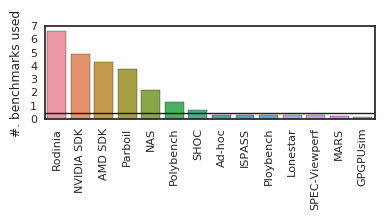

In [68]:
ax = sns.barplot(x="Benchmark Suite", y="#. benchmarks per paper", data=suites)
# threshold for benchmark suites used in paper:
plt.axhline(y=.5, color="k", lw=1)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel(""); plt.ylabel("#. benchmarks used")
viz.finalise(figsize=(4, 2.25), tight=True)

We selected the 7 most frequently used benchmark suites (used in 92% of
results), and evaluated the performance of the state of the art *Grewe et al.*
predictive model across each. Benchmark data:

In [73]:
amd_benchmarks = cgo13.LabelledData.from_csv('../data/amd-benchmarks.csv', group_by="suite")
amd_benchmarks

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,runtime,speedup,penalty,runtime_cpu,runtime_gpu,Group,F1_norm,F2_norm,F3_norm,F4_norm
0,amd-app-sdk-3.0-BinomialOption-binomial_options,default,98,8,13,11,2,0,2048,255,...,1.443983,2.28,0.44,3.291073,1.443983,amd-app-sdk-3.0,1.925432e-08,0.002275,0.505709,0.016180
1,amd-app-sdk-3.0-BitonicSort-bitonicSort,default,12,2,6,0,6,0,131072,256,...,0.121940,2.29,0.44,0.121940,0.279521,amd-app-sdk-3.0,7.599039e-06,0.014771,0.000000,0.004292
2,amd-app-sdk-3.0-BlackScholes-blackScholes,default,220,4,3,0,0,0,3145728,256,...,2.740855,2.22,0.45,6.076052,2.740855,amd-app-sdk-3.0,1.472101e-05,0.000000,0.000000,0.157296
3,amd-app-sdk-3.0-FastWalshTransform-fastWalshTr...,default,8,0,4,0,4,0,4096,256,...,0.130003,5.15,0.19,0.130003,0.668892,amd-app-sdk-3.0,3.562049e-07,0.014771,0.000000,0.004292
4,amd-app-sdk-3.0-FloydWarshall-floydWarshallPass,default,11,1,5,0,0,0,524288,256,...,0.283447,2.72,0.37,0.283447,0.769755,amd-app-sdk-3.0,3.419567e-05,0.000000,0.000000,0.004721
5,amd-app-sdk-3.0-MatrixMultiplication-mmmKernel,default,163,1,12,0,0,0,49152,64,...,0.277644,4.03,0.25,0.277644,1.120132,amd-app-sdk-3.0,2.931058e-07,0.000000,0.000000,0.029185
6,amd-app-sdk-3.0-MatrixTranspose-matrixTranspose,default,42,0,16,8,2,0,32768,256,...,0.156639,6.44,0.16,0.156639,1.009519,amd-app-sdk-3.0,5.895806e-07,0.001846,0.300000,0.005622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,shoc-1.1.5-Sort-top_scan,default,9,6,11,5,0,0,4198400,256,...,1.863657,1.01,0.99,1.885541,1.863657,shoc-1.1.5,2.190660e-04,0.000000,0.272727,0.001755
674,shoc-1.1.5-Spmv-spmv_csr_scalar_kernel,default,2,2,6,0,6,0,2000628,128,...,2.038006,3.43,0.29,2.038006,6.981001,shoc-1.1.5,2.609742e-04,0.014771,0.000000,0.000715


In [74]:
nvidia_benchmarks = cgo13.LabelledData.from_csv('../data/amd-benchmarks.csv', group_by="suite")
nvidia_benchmarks

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,runtime,speedup,penalty,runtime_cpu,runtime_gpu,Group,F1_norm,F2_norm,F3_norm,F4_norm
0,amd-app-sdk-3.0-BinomialOption-binomial_options,default,98,8,13,11,2,0,2048,255,...,1.443983,2.28,0.44,3.291073,1.443983,amd-app-sdk-3.0,1.925432e-08,0.002275,0.505709,0.016180
1,amd-app-sdk-3.0-BitonicSort-bitonicSort,default,12,2,6,0,6,0,131072,256,...,0.121940,2.29,0.44,0.121940,0.279521,amd-app-sdk-3.0,7.599039e-06,0.014771,0.000000,0.004292
2,amd-app-sdk-3.0-BlackScholes-blackScholes,default,220,4,3,0,0,0,3145728,256,...,2.740855,2.22,0.45,6.076052,2.740855,amd-app-sdk-3.0,1.472101e-05,0.000000,0.000000,0.157296
3,amd-app-sdk-3.0-FastWalshTransform-fastWalshTr...,default,8,0,4,0,4,0,4096,256,...,0.130003,5.15,0.19,0.130003,0.668892,amd-app-sdk-3.0,3.562049e-07,0.014771,0.000000,0.004292
4,amd-app-sdk-3.0-FloydWarshall-floydWarshallPass,default,11,1,5,0,0,0,524288,256,...,0.283447,2.72,0.37,0.283447,0.769755,amd-app-sdk-3.0,3.419567e-05,0.000000,0.000000,0.004721
5,amd-app-sdk-3.0-MatrixMultiplication-mmmKernel,default,163,1,12,0,0,0,49152,64,...,0.277644,4.03,0.25,0.277644,1.120132,amd-app-sdk-3.0,2.931058e-07,0.000000,0.000000,0.029185
6,amd-app-sdk-3.0-MatrixTranspose-matrixTranspose,default,42,0,16,8,2,0,32768,256,...,0.156639,6.44,0.16,0.156639,1.009519,amd-app-sdk-3.0,5.895806e-07,0.001846,0.300000,0.005622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,shoc-1.1.5-Sort-top_scan,default,9,6,11,5,0,0,4198400,256,...,1.863657,1.01,0.99,1.885541,1.863657,shoc-1.1.5,2.190660e-04,0.000000,0.272727,0.001755
674,shoc-1.1.5-Spmv-spmv_csr_scalar_kernel,default,2,2,6,0,6,0,2000628,128,...,2.038006,3.43,0.29,2.038006,6.981001,shoc-1.1.5,2.609742e-04,0.014771,0.000000,0.000715


The *Grewe et al.* model predicts whether running a given OpenCL kernel on the GPU gives better
performance than on the CPU. The performance of a model trained on one benchmark
suite and used to predict the optimal mapping for another suites is generally
very poor.

**Table 1:** Performance relative to the optimal of the *Grewe et al.* predictive model across different benchmark suites on an AMD GPU. The columns show the suite used for training; the rows show the suite used for testing.

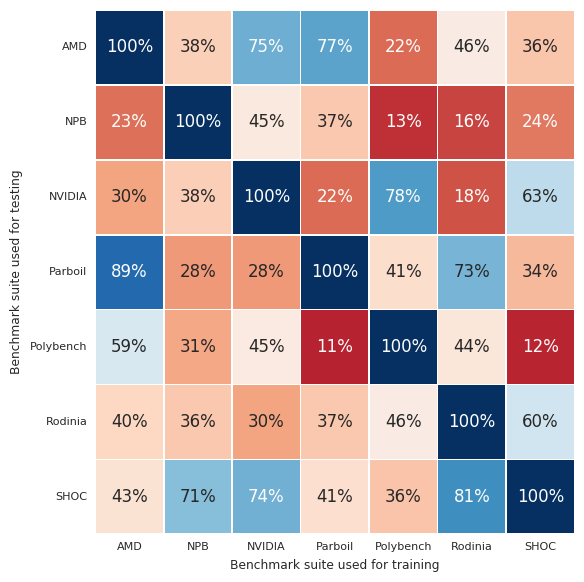

In [75]:
data = amd_benchmarks
metrics = cgo13.classification(data, group_by="suite")
results = np.zeros((len(metrics), len(metrics[0])))

for j in range(len(metrics)):
    for i in range(len(metrics[j])):
        results[j, i] = metrics[j][i].oracle * 100  # % optimal
results = results.T

groups = sorted(set(data["Group"]))

ax = sns.heatmap(results, annot=True, fmt=".0f", linewidths=.5,
                 xticklabels=shortlabels(groups),
                 yticklabels=shortlabels(groups), cbar=False,
                 cmap="RdBu", center=50, vmin=0, vmax=100)
for t in ax.texts:
    t.set_text(t.get_text() + "%")
plt.xlabel("Benchmark suite used for training")
plt.ylabel("Benchmark suite used for testing")
viz.finalise(figsize=(6, 6), tight=True)

The benchmark suite which provides the best results, NVIDIA SDK,
achieves on average only 49% of the optimal performance. The worst case is when
training with Parboil to predict the optimal mappings for Polybench, where the
model achieves only 11.5% of the optimal performance. It is clear that
heuristics learned on one benchmark suite fail to generalize across other
suites. This problem is caused both by the limited number of benchmarks contained in
each suite, and the distribution of benchmarks within the feature space.

**Figure 3a**: A two dimensional projection of the Grewe
et al. predictive model over Parboil benchmarks on
an NVIDIA GPU.

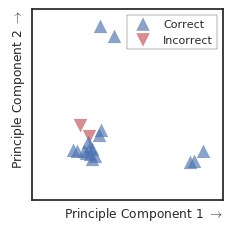

In [84]:
clf = cgo13.model()
parboil = nvidia_benchmarks[nvidia_benchmarks["benchmark"].str.contains(r"^parboil-")]

B_out = cgo13.xval_benchmarks(clf, parboil)

pca = PCA(n_components=2)
pca.fit(cgo13.raw_features(parboil))

X = pca.transform(cgo13.raw_features(parboil))

ax = plot_pca(X, B_out)

xlim = ax.get_xlim()  # we'll use these for the next plot
ylim = ax.get_ylim()

viz.finalise(figsize=(2.5, 2.5), tight=True)

As we see, there is a dense cluster of neighboring benchmarks, a smaller cluster
of three benchmarks, and two outliers. The lack of neighboring observations
means that the model is unable to learn a good heuristic for the two outliers,
which leads to them being incorrectly optimized. Now we train the predictive
model with additional benchmarks which are neighboring in the feature space.

**Figure 3b:** Two outliers in (a) are incorrectly predicted due to the lack of nearby observations. The additional neighboring observations in (b) corrects this.

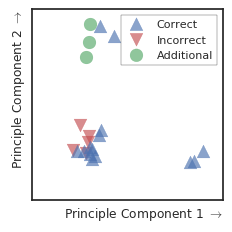

In [85]:
clf = clone(clf)  # reset model

additional_benchmarks = [
    "shoc-1.1.5-FFT-ifft1D_512",
    "shoc-1.1.5-S3D-ratt6_kernel",
    "shoc-1.1.5-S3D-ratx2_kernel",
    "shoc-1.1.5-S3D-ratt9_kernel",
]

additional = nvidia_benchmarks[nvidia_benchmarks["benchmark"].str.contains(
    "|".join(additional_benchmarks))]
parboil_and_additional = nvidia_benchmarks[nvidia_benchmarks["benchmark"].str.contains(
    r"^{}|{}".format("parboil", "|".join(additional_benchmarks)))]

B_out = cgo13.xval_benchmarks(clf, parboil_and_additional, prefix="parboil")

X = pca.transform(cgo13.raw_features(parboil))

ax = plot_pca(X, B_out, additional, pca)

ax.set_xlim(xlim)  # use same axis as before
ax.set_ylim(ylim)

viz.finalise(figsize=(2.5, 2.5), tight=True)

The addition of these observations (and the information they provide about that
part of the feature space) causes the two outliers to be correctly optimized. We
found such outliers in all of the benchmark suites.

These results highlight the significant affect that the number and distribution
of training programs has on the quality of predictive models. Without good
coverage of the feature space, any machine learning methodology is unlikely to
produce high quality heuristics, suitable for general use on arbitrary real
applications. Our novel approach, described in the next section, solves this
problem by generating an unbounded number of programs to cover the feature space
at any desired granularity.

# 3. Overview of Our Approach

In this paper we present CLgen, a tool for synthesizing OpenCL benchmarks, and
an accompanying host driver for executing synthetic benchmarks for gathering
performance data for predictive modeling. While we demonstrate our approach
using OpenCL, it is language agnostic. Our tool CLgen learns the semantics and
structure from over a million lines of hand-written code from GitHub, and
synthesizes programs through a process of iterative model sampling. We then use
a host driver to execute the synthesized programs to gather performance data for
use in predictive modeling. Our approach extends the state of the art by
providing a general-purpose solution for benchmark synthesis, leading to better
and more accurate predictive models.

In the course of evaluating our technique against prior work we discovered that
it is also useful for evaluating the quality of features. Since we are able to
cover the space so much more finely than the prior work, which only used
standard benchmark suites, we are able to find multiple programs with identical
feature values but different best heuristic values. This indicates that the
features are not sufficiently discriminative and should be extended with more
information to allow those programs to be separated. We go on to show that doing
this significantly increases the performance of the learned heuristics. We
expect that our technique will be valuable for feature designers.

# 4. CLgen: Benchmark Synthesis

CLgen is an undirected, general-purpose program synthesizer for OpenCL. It
adopts and augments recent advanced techniques from deep learning to learn over
massive codebases. In contrast to existing grammar and template based
approaches, CLgen is entirely probabilistic. It *learns* to program using neural
networks which model the semantics and usage of a huge corpus of code fragments
in the target programming language. This section describes the assembly of an
OpenCL language corpus, the application of deep learning over this corpus, and
the process of synthesizing programs.

## 4.1. An OpenCL Language Corpus

Deep learning requires large datasets. For the purpose of modeling a programming
language, this means assembling a very large collection of real, hand-written
source codes. We assembled OpenCL codes by mining public repositories on the
popular code hosting site GitHub.

This is itself a challenging task since OpenCL is an embedded language, meaning
device code is often difficult to untangle and GitHub does not presently
recognize it as a searchable programming language. We developed a search engine
for the GitHub API which attempts to identify and download standalone OpenCL
files through a process of file scraping and recursive header inlining.

The dataset we mined (from June 2016):

In [10]:
import clgen.dbutil

data = "../data/github.db"
print("# content files:", clgen.dbutil.num_rows_in(data, "ContentFiles"))
print("line count:     ", clgen.dbutil.lc(data, "ContentFiles"))

# content files: 8078
line count:      2852707


Randomly selected file *(replay cell to select a new file)*:

In [11]:
db = clgen.dbutil.connect("../data/github.db").cursor()
db.execute("SELECT Contents FROM ContentFiles ORDER BY RANDOM() LIMIT 1")
print(db.fetchone()[0])
db.close()


//OpenCL
//MAX_GLOBAL_SIZE(0):-1
//MAX_GLOBAL_SIZE(1):1
//MAX_GLOBAL_SIZE(2):1
//MAX_LOCAL_SIZE(0):0
//MAX_LOCAL_SIZE(1):1
//MAX_LOCAL_SIZE(2):1
//MIN_LOCAL_SIZE:32

kernel void lfsr_64(global int* buffer1, global int*buffer2, int buffer_size)
{
  ulong reg = buffer1[get_global_id(0)];

  for (int i = 0; i < 1024; i++)
  {
    reg = (reg >> 1) ^ (-(reg & 1UL) & 0xD800000000000000L);
  }
  
  buffer2[get_global_id(0)] = reg;
}

//Gold

void lfsr_64(void* buffer1, void* buffer2, int buffer_size)
{
  for (int i = 0; i <  buffer_size; i++)
  {
    unsigned long reg = ((int*)buffer1)[i];
    
    for (int w = 0; w < 1024; w++)
    {
      reg = (reg >> 1) ^ (-(reg & 1UL) & 0xD800000000000000L);
    }
    
    ((int*)buffer2)[i] = reg; 
  }
}



We prune the raw dataset extracted from GitHub using a custom toolchain we
developed for rejection filtering and code rewriting, built on LLVM.

In [89]:
# To replicate the mining of GitHub for OpenCL files:
#
# Generate an API token by following the instructions here:
#   https://help.github.com/articles/creating-an-access-token-for-command-line-use/>
# 
# From the command line, run:
#
#   $ export GITHUB_USERNAME=[your-username]
#   $ export GITHUB_PW=[your-password]
#   $ export GITHUB_TOKEN=[your-api-token]
#   $ clgen-create-db --github github.db
#   $ clgen-fetch-github github.db
#
# This process issues thousands of GitHub API requests per minute over the course of several hours.
# Please exercise restrained in minimizing your use of this program -- we don't want to upset
# the nice folks at GH :-)

#### Rejection Filter

The rejection filter accepts as input a content file and returns whether or not
it contains compilable, executable OpenCL code. To do this we attempt to compile
the input to NVIDIA PTX bytecode and perform static analysis to ensure a minimum
static instruction count of three. We discard any inputs which do not compile or
contain fewer than three instructions.

Bytecode features of an example program:

In [12]:
bc = clgen.preprocess.compile_cl_bytecode("""
#define DTYPE float
#define ALPHA(a) 3.5f * a
inline DTYPE ax(DTYPE x) { return ALPHA(x); }

__kernel void saxpy( /* SAXPY kernel */
    __global DTYPE *input1,
    __global DTYPE *input2,
    const int nelem)
{
    unsigned int idx = get_global_id(0);
    // = ax + y
    if (idx < nelem) {
        input2[idx] += ax(input1[idx]); }}
""")
clgen.preprocess.bytecode_features(bc)

{'And_insts': 1,
 'Br_insts': 2,
 'Call_insts': 1,
 'FAdd_insts': 1,
 'FMul_insts': 1,
 'GetElementPtr_insts': 2,
 'ICmp_insts': 1,
 'Load_insts': 2,
 'Ret_insts': 1,
 'Store_insts': 1,
 'Trunc_insts': 1,
 'basic_blocks': 3,
 'instructions_of_all_types': 14,
 'memory_instructions': 6,
 'non_external_functions': 1,
 'ratio_And_insts': 0.07142857142857142,
 'ratio_Br_insts': 0.14285714285714285,
 'ratio_Call_insts': 0.07142857142857142,
 'ratio_FAdd_insts': 0.07142857142857142,
 'ratio_FMul_insts': 0.07142857142857142,
 'ratio_GetElementPtr_insts': 0.14285714285714285,
 'ratio_ICmp_insts': 0.07142857142857142,
 'ratio_Load_insts': 0.14285714285714285,
 'ratio_Ret_insts': 0.07142857142857142,
 'ratio_Store_insts': 0.07142857142857142,
 'ratio_Trunc_insts': 0.07142857142857142,
 'ratio_basic_blocks': 0.21428571428571427,
 'ratio_memory_instructions': 0.42857142857142855,
 'ratio_non_external_functions': 0.07142857142857142}

During initial development it became apparent that isolating the OpenCL device
code leads to a higher-than-expected discard rate (that is, seemingly valid
OpenCL files being rejected). Through analyzing 148k lines of compilation
errors, we discovered a large number of failures caused by undeclared
identifiers — a result of isolating device code — 50% of undeclared identifier
errors in the GitHub dataset were caused by only 60 unique identifiers. To
address this, we developed a *shim header* which contains inferred values for
common type definitions (e.g. `FLOAT_T`), and common constants (e.g. `WGSIZE`).

**Listing 1::** The shim header file, providing inferred type aliases and constants for OpenCL on GitHub.

In [13]:
import clgen.native
print(readfile(clgen.native.SHIMFILE))

// Enable OpenCL features and implementation.
#ifndef CLGEN_FEATURES
#define cl_clang_storage_class_specifiers
#define cl_khr_fp64
#include <clc/clc.h>
#pragma OPENCL EXTENSION cl_khr_fp64 : enable

#define __CL_VERSION_1_0__
#define __CL_VERSION_1_1__
#define __CL_VERSION_1_2__
#define __ENDIAN_LITTLE__
#define __FAST_RELAXED_MATH__
#define __IMAGE_SUPPORT__
#define __OPENCL_VERSION__ 1
#endif  /* CLGEN_FEATURES */

// Unsupported OpenCL storage classes and qualifiers.
#define static
#define generic
#define AS

// Common typedefs
typedef float CONVT;
typedef float DATA_TYPE;
typedef float DATATYPE;
typedef float FLOAT_T;
typedef float FLOAT_TYPE;
typedef float FPTYPE;
typedef float hmc_float;
typedef float inType;
typedef float outType;
typedef float real;
typedef float REAL;
/* typedef float T; */
typedef float Ty;
typedef float TyOut;
typedef float TYPE;
typedef float VALTYPE;
typedef float VALUE_TYPE;
typedef float VECTYPE;
typedef float WORKTYPE;
typedef float2 hmc_complex;
typede

In [14]:
# without shim:
try:
    clgen.preprocess.preprocess("""
        __kernel void foo(__global float* a) {
            a[get_global_id(0)] = ZERO;
        }
    """, use_shim=False)
except clgen.preprocess.BadCodeException:
    print("fails to compile without shim")

fails to compile without shim


In [15]:
# with shim:
print(clgen.preprocess.preprocess("""
    __kernel void foo(__global float* a) {
        a[get_global_id(0)] = ZERO;
    }
""", use_shim=True))

__kernel void A(__global float* a) {
  a[get_global_id(0)] = 0;
}


Injecting the shim decreases the discard rate from 40% to 32%, responsible for
an additional 88k lines of code in the final language corpus. The resulting
dataset is 2.0 million lines of compilable OpenCL source code.

In [16]:
def linecount_of_good_files(data):
    db = clgen.dbutil.connect(data).cursor()
    db.execute("""SELECT LC(ContentFiles.Contents) FROM ContentFiles
               LEFT JOIN PreprocessedFiles ON ContentFiles.id=PreprocessedFiles.id
               WHERE PreprocessedFiles.status=0""")
    return db.fetchone()[0]

data = "../data/github.db"

# preprocess dataset
# note results are cached. empty cache by uncommenting the next line (will take >30min):
# clgen.dbutil.remove_preprocessed(data)
clgen.preprocess.preprocess_db(data)

num_good_files = clgen.dbutil.num_rows_in(data, "PreprocessedFiles", condition="WHERE status=0")
num_bad_files = clgen.dbutil.num_rows_in(data, "PreprocessedFiles", condition="WHERE status!=0")
ratio_bad = num_bad_files / (num_good_files + num_bad_files)

print("# files in final dataset:", num_good_files)
print("# rejected files:        ", num_bad_files, "({:.0f}%)".format(ratio_bad * 100))
print("line count of good files:", linecount_of_good_files(data))

# files in final dataset: 5390
# rejected files:         2688 (33%)
line count of good files: 2014761


#### Code Rewriting

Programming languages have few of the issues of semantic interpretation present
in natural language, though there remains many sources of variance at the
syntactic level. For example, the presence and content of comments in code, and
the choice of identifying names given to variables. We consider these
ambiguities to be *non-functional variance*, and developed a tool to normalize
code of these variances so as to make the code more amenable to machine
learning. This is a three step process:

1.  The source is pre-processed to remove macros, conditional compilation, and
    source comments.

2.  Identifiers are rewritten to have a short but unique name based on their
    order of appearance, using the sequential series $\{a, b, c,
    \ldots, aa, ab, ac, \ldots\}$
    for variables and $\{A, B, C,
    \ldots, AA, AB, AC, \ldots\}$
    for functions. This process isolates the syntactic structure of the code,
    and unlike prior work, our rewrite method preserves program behavior.
    Language built-ins (e.g. `get_global_id`, `asin`) are not rewritten.

3.  A variant of the Google C++ code style is enforced to ensure consistent use
    of braces, parentheses, and white space.
    
**Figure 5:**  The code rewriting process, which transforms code to make it more amenable to language modeling.

In [17]:
print(clgen.preprocess.preprocess("""
#define DTYPE float
#define ALPHA(a) 3.5f * a
inline DTYPE ax(DTYPE x) { return ALPHA(x); }

__kernel void saxpy( /* SAXPY kernel */
    __global DTYPE *input1,
    __global DTYPE *input2,
    const int nelem)
{
    unsigned int idx = get_global_id(0);
    // = ax + y
    if (idx < nelem) {
        input2[idx] += ax(input1[idx]); }}
"""))

inline float A(float a) {
  return 3.5f * a;
}

__kernel void B(__global float* b, __global float* c, const int d) {
  unsigned int e = get_global_id(0);

  if (e < d) {
    c[e] += A(b[e]);
  }
}


Randomly selected preprocessed file from dataset *(replay cell to select a new file)*:

In [18]:
db = clgen.dbutil.connect("../data/github.db").cursor()
db.execute("SELECT Contents FROM PreprocessedFiles WHERE status=0 ORDER BY RANDOM() LIMIT 1")
print(db.fetchone()[0])
db.close()

__kernel void A(__global float* a, __global float* b, __global float* c) {
  unsigned int d = get_global_id(0);

  c[d] = a[d] + b[d];
}


A side effect of this process is a reduction in code size, largely due to the
removal of comments and excess white space. The final language corpus contains
1.3 million lines of transformed OpenCL, consisting of 9487 kernel functions.
Identifier rewriting reduces the bag-of-words vocabulary size by 84%.

In [19]:
import clgen.train

db = clgen.dbutil.connect("../data/github.db")
clgen.train.create_corpus(db, "../data/corpus.cl", gh=True)

lc, wc, cc = line_word_char_count("../data/corpus.cl")
print("  #. lines:", lc)
print("  #. words:", wc)
print("  #. chars:", cc)

creating DNN corpus ../data/corpus.cl ...
writing file ../data/corpus.cl
  #. lines: 1283985
  #. words: 7394398
  #. chars: 32557439


## 4.2. Learning OpenCL

Generating valid, executable program code is an ambitious and
challenging goal for machine learning. We employ state of the art deep
language modeling techniques to achieve this task.

We use the Long Short-Term Memory (LSTM) architecture of Recurrent Neural
Network to learn a character-level language model over the corpus of OpenCL
compute kernels. The LSTM network architecture comprises recurrent layers of
*memory cells*, each consisting of an input, output, and forget gate, and an
output layer providing normalized probability values from a 1-of-K coded
vocabulary.

We use a 3-layer LSTM network with 2048 nodes per layer. We train this
17-million parameter model using *Stochastic Gradient Descent* for 50 epochs,
using an initial learning rate of 0.002, decaying by a factor of one half every
5 epochs. Training took three weeks on a single machine using an NVIDIA GTX
Titan, with a final model size of 648MB. Training the network is a one-off cost,
and can be parallelized across devices. The trained network can be deployed to
lower-compute machines for use.

In [20]:
import clgen.model

print("Training a tiny network on a tiny dataset:")
tiny_model = clgen.model.from_json({
        "corpus": {
            "path": "../data/tiny-corpus"
        },
        "train_opts": {
            "model_type": "lstm",
            "rnn_size": 32,
            "num_layers": 2,
            "max_epochs": 1
        }
    })
tiny_model.cache.empty()
print(tiny_model.corpus)
tiny_model.train()
tiny_model

Training a tiny network on a tiny dataset:
corpus of 73 files
Running with CUDA on GPU 0	
Epoch 1.06 / 1, i = 10 / 175, loss = 3.788313	
Epoch 1.11 / 1, i = 20 / 175, loss = 3.082000	
Epoch 1.17 / 1, i = 30 / 175, loss = 2.684211	
Epoch 1.23 / 1, i = 40 / 175, loss = 2.613900	
Epoch 1.29 / 1, i = 50 / 175, loss = 2.551519	
Epoch 1.34 / 1, i = 60 / 175, loss = 2.563629	
Epoch 1.40 / 1, i = 70 / 175, loss = 2.581497	
Epoch 1.46 / 1, i = 80 / 175, loss = 2.556917	
Epoch 1.51 / 1, i = 90 / 175, loss = 2.481185	
Epoch 1.57 / 1, i = 100 / 175, loss = 2.450182	
val_loss = 	2.752627770106	
Epoch 1.63 / 1, i = 110 / 175, loss = 2.384481	
Epoch 1.69 / 1, i = 120 / 175, loss = 2.271564	
Epoch 1.74 / 1, i = 130 / 175, loss = 2.210940	
Epoch 1.80 / 1, i = 140 / 175, loss = 2.116411	
Epoch 1.86 / 1, i = 150 / 175, loss = 2.028911	
Epoch 1.91 / 1, i = 160 / 175, loss = 2.034931	
Epoch 1.97 / 1, i = 170 / 175, loss = 1.854259	
val_loss = 	2.2008840015956	


58a6cea90b3b67a144bb5f61acf730b3537fc8f4: {
  "max_epochs": 1,
  "model_type": "lstm",
  "num_layers": 2,
  "rnn_size": 32
}

In [21]:
print("The model used in the paper (pre-trained):")
model = clgen.model.from_tar("../data/clgen-github-model-2016-nov-2048x3.tar.bz2")
model

The model used in the paper (pre-trained):


f2fb3ad753896d54fe284c138eaa703db3518bbb: {
  "max_epochs": 50,
  "model_type": "lstm",
  "num_layers": 3,
  "rnn_size": 2048
}

## 4.3. Synthesizing OpenCL

We synthesize OpenCL compute kernels by iteratively sampling the learned
language model. We implemented two modes for model sampling: the first involves
providing an *argument specification*, stating the data types and modifiers of
all kernel arguments. When an argument specification is provided, the model
synthesizes kernels matching this signature. In the second sampling mode this
argument specification is omitted, allowing the model to synthesize compute
kernels of arbitrary signatures, dictated by the distribution of argument types
within the language corpus.

In either mode we generate a *seed* text:

In [22]:
print(clgen.sampler.serialize_argspec([
    '__global float*',
    '__global float*',
    '__global float*',
    'const int'
]))

__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {


In [23]:
print(clgen.sampler.serialize_argspec([
    '__global int*',
    'const int'
]))

__kernel void A(__global int* a, const int b) {


In [24]:
print(clgen.sampler.serialize_argspec([
    '__global int*',
    'const int'
]))

__kernel void A(__global int* a, const int b) {


We then sample the model, character by character, until the end of the compute kernel is reached, or until a
predetermined maximum number of characters is reached.

Live demos (re-run to re-sample):

In [25]:
import clgen.sampler

argspec = ['__global float*', '__global float*', '__global float*', 'const int']

sampler = clgen.sampler.from_json({
        "kernels": { 
            "args": argspec,
            "max_length": 300,
        },
        "sampler": {
            "batch_size": 1,
            "max_batches": 1
        }
    })

print("Sample from the tiny model we just trained:")
sampler.sample(tiny_model)

Sample from the tiny model we just trained:
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) { k & &
 =  i; =  g =)
   & (* & / g  ( h i  & ;) = i = + a 0))   (o; 0 )
  h = =) ( k i k)) 1)  
kernel 1

Number of content files:            6

Number of unique content files:     6 (100%)
Total content line count:           35
Content file line counts:           min: 2, med: 4, avg: 6, max: 14

Number of good preprocessed files:  0 (0%)
Lines of good preprocessed code:    0 (0%)
Good preprocessed line counts:      min: 0, med: 0, avg: 0, max: 0



In [26]:
print("Sample from the model used in the paper:")
sampler.sample(model)

Sample from the model used in the paper:
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < c)
    a[e * b + d] = 0x1.fffffep123
    761617.0 / 16;
kernel 1

Number of content files:            6

Number of unique content files:     6 (100%)
Total content line count:           45
Content file line counts:           min: 7, med: 7, avg: 8, max: 9

Number of good preprocessed files:  2 (33%)
Lines of good preprocessed code:    16 (36%)
Good preprocessed line counts:      min: 7, med: 8, avg: 8, max: 9



The rejection filter then either accepts or rejects the sample as a candidate synthetic benchmark

Live demo which generates a single statically-verified OpenCL kernel using the pre-trained network:

In [27]:
print("Generate a statically checked kernel using the pre-trained network:")
sampler = clgen.sampler.from_json({
        "kernels": { 
            "args": argspec,
            "max_length": 500,
        },
        "sampler": {
            "batch_size": 5,
            "max_kernels": 1
        }
    })

sampler.cache(model).empty()
sampler.sample(model)
print("done.")

Generate a statically checked kernel using the pre-trained network:


/* === SAMPLE 1 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);
  int f = get_global_id(1);
  int g = g + d * f;
  int h = f + c;
  e %= 1;

  size_t q = g * c / e;
  int r = f + 1;

  if (d >= 0 && d < r) {
    int s = (a[h + 1] - b[h - 1 - t]) * (a[h + 1] - a[j - 1]);
    int t = ((at + 1) < (d - 1) ? (ah - 1) : (i - 1));

    s[s] = ((float)q) * (1.0f - t) < (v + 1) ? a[n] : 0;
    v[p]++;
  }

  uint v = c * d;

  uint v = t[0];
  uint w = 

/* === SAMPLE 2 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < d) {
    float f = a[f];
    float g = a[f];
    float h = e[f];

    a[e] = h;
  }
}

/* === SAMPLE 3 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);
  int f = e << 4;
  for (i

# 5. Benchmark Execution

We developed a host driver to gather performance data from synthesized CLgen
code. The driver accepts as input an OpenCL kernel, generates *payloads* of
user-configurable sizes, and executes the kernel using the generated payloads,
providing dynamic checking of kernel behavior.

In [28]:
import clgen.cldrive, clgen.preprocess

src = clgen.preprocess.preprocess("""
__kernel void benchmark(__global float* a, __global float* b, const float c, const int n) {
   const int i = get_global_id(0);
   if (i < n)
     a[i] += c * b[i];
}
""")

if has_opencl():
    ctx, queue = clgen.cldrive.init_opencl()
    driver = clgen.cldrive.KernelDriver(ctx, src)
    print(driver)
else:
    print("no OpenCL support, skipped", file=sys.stderr)

__kernel void A(__global float* a, __global float* b, const float c, const int d) {
  const int e = get_global_id(0);
  if (e < d)
    a[e] += c * b[e];
}


## 5.1. Generating Payloads

A *payload* encapsulates all of the arguments of an OpenCL compute kernel. After
parsing the input kernel to derive argument types, a rule-based approach is used
to generate synthetic payloads. For a given global size $S_g$: host buffers of
$S_g$ elements are allocated and populated with random values for global pointer
arguments, device-only buffers of $S_g$ elements are allocated for local pointer
arguments, integral arguments are given the value $S_g$, and all other scalar
arguments are given random values. Host to device data transfers are enqueued
for all non-write-only global buffers, and all non-read-only global buffers are
transferred back to the host after kernel execution.

In [29]:
if has_opencl():
    size = 4096
    payload = clgen.cldrive.KernelPayload.create_random(driver, size)
    print(payload)
else:
    print("no OpenCL support, skipped", file=sys.stderr)

Payload on host:
  arg 0: ndarray size: 4096 [ 0.88661683  0.83743018  0.22631161 ...,  0.65187323  0.05996597
  0.36629924]
  arg 1: ndarray size: 4096 [ 0.4669764   0.55964804  0.47492531 ...,  0.19213973  0.65404087
  0.97557777]
  arg 2: None
  arg 3: None

Payload on device:
  arg 0: Buffer size: 16384 <pyopencl.cffi_cl.Buffer object at 0x7f91ec56f5c0>
  arg 1: Buffer size: 16384 <pyopencl.cffi_cl.Buffer object at 0x7f91ec56f6a0>
  arg 2: float32 val: 4096.0
  arg 3: int32 val: 4096



## 5.2. Dynamic Checker

For the purpose of performance benchmarking we are not interested in the
correctness of computed values, but we define a class of programs as performing
*useful work* if they predictably compute some result. We devised a low-overhead
runtime behavior check to validate that a synthesized program does useful work
based on the outcome of four executions of a tested program:

**Step 1:** Create 4 equal size payloads $A_{1in}$, $B_{1in}$, $A_{2in}$, $B_{2in}$,
    subject to restrictions: $A_{1in}=A_{2in}$, $B_{1in}=B_{2in}$, $A_{1in} \ne
    B_{1in}$.

In [30]:
from copy import deepcopy

if has_opencl():
    # create payloads
    A1in = clgen.cldrive.KernelPayload.create_sequential(driver, size)
    A2in = deepcopy(A1in)

    B1in = clgen.cldrive.KernelPayload.create_random(driver, size)
    B2in = deepcopy(B1in)

    # check contstraints
    assert(A1in == A2in)
    assert(B1in == B2in)
    assert(A1in != B1in)
else:
    print("no OpenCL support, skipped", file=sys.stderr)

**Step 2:** Execute kernel $k$ 4 times: $k(A_{1in}) \rightarrow A_{1out}$, $k(B_{1in})
   \rightarrow B_{1out}$, $k(A_{2in}) \rightarrow A_{2out}$, $k(B_{2in})
   \rightarrow B_{2out}$.

In [31]:
if has_opencl():
    k = partial(driver, queue)
    A1out = k(A1in)
    B1out = k(B1in)
    A2out = k(A2in)
    B2out = k(B2in)
else:
    print("no OpenCL support, skipped", file=sys.stderr)

**Step 3:**  Assert:

* $A_{1out} \ne A_{1in}$ and $B_{1out} \ne B_{1in}$, else $k$ has no output (for these inputs).

* $A_{1out} \ne B_{1out}$ and $A_{2out} \ne B_{2out}$, else $k$ is input insensitive (for these inputs).

* $A_{1out}=A_{2out}$ and $B_{1out}=B_{2out}$, else $k$ is non-deterministic.

In [32]:
if has_opencl():
    # outputs must be consistent across runs:
    assert(A1out == A2out)
    assert(B1out == B2out)

    # outputs must depend on inputs:
    if any(not x.is_const for x in driver.prototype.args):
        assert(A1out != B1out)

    # outputs must be different from inputs:
    assert(A1in != A1out)
    assert(B1in != B1out)
else:
    print("no OpenCL support, skipped", file=sys.stderr)

Equality checks for floating point values are performed with an appropriate
epsilon to accommodate rounding errors, and a timeout threshold is also used to
catch kernels which are non-terminating. Our method is based on random
differential testing, though we emphasize that this is not a general purpose
approach and is tailored specifically for our use case. For example, we
anticipate a false positive rate for kernels with subtle sources of
non-determinism which more thorough methods may expose, however we deemed such
methods unnecessary for our purpose of performance modeling.

Examples of programs which are our dynamic checker catches:

In [33]:
driver = clgen.cldrive.KernelDriver(ctx, """
__kernel void A(__global int* a) {}
""")

try:
    driver.validate(queue, 8192)
except clgen.cldrive.E_NO_OUTPUTS:
    print("caught kernel with no outputs")
except clgen.cldrive.OpenCLNotSupported:
    print("no OpenCL support, skipped", file=sys.stderr)

caught kernel with no outputs


In [34]:
driver = clgen.cldrive.KernelDriver(ctx, """
__kernel void A(__global int* a) {
  int b = get_global_id(0);
  a[b] = 0;
}""")

try:
    driver.validate(queue, 8192)
except clgen.cldrive.E_INPUT_INSENSITIVE:
    print("caught input-insensitive kernel")
except clgen.cldrive.OpenCLNotSupported:
    print("no OpenCL support, skipped", file=sys.stderr)

caught input-insensitive kernel


In [35]:
driver = clgen.cldrive.KernelDriver(ctx, """
__kernel void A(__global float* a) {
  int b = get_global_id(0);

  a[b] = a[b-1] + a[b+1]; /* race condition */
}""")

try:
    driver.validate(queue, 8192)
except clgen.cldrive.E_NONDETERMINISTIC:
    print("caught non-deterministic kernel")
except clgen.cldrive.OpenCLNotSupported:
    print("no OpenCL support, skipped", file=sys.stderr)

caught non-deterministic kernel


# 6. Evaluation of Synthetic Programs

In this section we evaluate the quality of programs synthesized by CLgen
by their likeness to hand-written code, and discuss limitations of the
synthesis and execution pipeline.

## 6.1. Likeness to hand-written code

Judging whether a source code was written by a human is a challenging task for a
machine, so we adopt a methodology from machine learning research based on the
*Turing Test*. We reason that if the output of CLgen is human like code, then a
human judge will be unable to distinguish it from hand-written code.

We devised a double blind test in which 15 volunteer OpenCL developers from
industry and academia were shown 10 OpenCL kernels each. Participants were
tasked with judging whether, for each kernel, they believed it to have been
written by hand or by machine. Kernels were randomly selected for each
participant from two equal sized pools of synthetically generated and hand-
written code from GitHub.

The participants were divided into two groups, with 10 of them receiving code
generated by CLgen, and 5 of them acting as a control group, receiving code
generated by CLSmith, a program generator for differential testing.

In [36]:
data = pd.read_csv("../data/turing-test.csv")
data["Score (%)"] = (data["True Positive"] + data["True Negative"]) * 10
data

,Test ID,Synthetic Source,Affiliation,True Positive,False Positive,True Negative,False Negative,Score (%)
0,5e8f,CLSmith,University of Edinburgh,5,0,5,0,100
1,4da2,CLgen,University of Edinburgh,3,2,4,1,70
2,b323,CLgen,Codeplay,5,2,3,0,80
3,5e69,CLSmith,University of Edinburgh,5,0,3,2,80
4,5ddf,CLSmith,University of Edinburgh,4,0,6,0,100
5,97ac,CLgen,University of Edinburgh,1,3,3,3,40
6,b2ce,CLgen,University of Edinburgh,4,1,3,2,70
7,5d56,CLSmith,University of Edinburgh,5,0,5,0,100
8,b2d5,CLgen,Codeplay,2,3,2,3,40
9,b2d3,CLgen,Codeplay,2,2,2,4,40


Analysis of participant’s answers:

In [37]:
clgen_data   = data[data["Synthetic Source"].str.contains("CLgen")]
clsmith_data = data[data["Synthetic Source"].str.contains("CLSmith")]

print("Mean CLgen score:  ", round(  clgen_data["Score (%)"].mean(), 1), "%, stdev:",
      round(  clgen_data["Score (%)"].std(), 1), "%")
print("Mean CLSmith score:", round(clsmith_data["Score (%)"].mean(), 1), "%, stdev:",
      round(clsmith_data["Score (%)"].std(), 1), "%")

Mean CLgen score:   52.0 %, stdev: 16.9 %
Mean CLSmith score: 96.0 %, stdev: 8.9 %


This an unsurprising outcome as generated programs for
testing have multiple “tells”, for example, their only input is a single `ulong`
pointer. This demonstrates that CLgen code is indistinguishable from hand-written
programs, with human judges scoring no better than random chance.

An online game of this test is available [here](http://humanorrobot.uk/game/?g=opencl&m=nitt).

## 6.2. Limitations

Our new approach enables the synthesis of more human-like programs than current
state of the art program generators, and without the expert guidance required by
template based generators, but it has limitations. Currently we only run single-
kernel benchmarks, and our method of seeding the language models with the start
of a function means that we cannot support user defined types, or calls to user-
defined functions. The first limitation will be overcome by extending the host
driver to explore multi-kernel schedules and interleaving of kernel executions.
The second limitation can be addressed through recursive program synthesis,
whereby a call to a user-defined function or type will trigger candidate
functions and types to be synthesized.

# 7. Experimental Methodology

## 7.1. Experimental Setup 

#### Predictive Model

We reproduce the predictive model from Grewe et al. (2013). The predictive model
is used to determine the optimal mapping of a given OpenCL kernel to either a
GPU or CPU. It uses supervised learning to construct a decision tree with a
combination of static and dynamic kernel features extracted from source code and
the OpenCL runtime.

In [38]:
def features_to_dict(path):
    import clgen.features
    buf = StringIO()
    clgen.features.feature_headers(file=buf)  # feature names
    keys = buf.getvalue().rstrip().split(",")
    buf = StringIO()
    clgen.features.features(path, file=buf)  # extract features
    values = buf.getvalue().rstrip().split(",")
    return dict((k, v) for k, v in zip(keys, values))

# kernel to get features from:
kernel = """
__kernel void foobar(__global float *a, __global float *b, const int n) {
    unsigned int i = get_global_id(0);
    if (i < n)
        b[i] += a[i] * 2; 
}
"""
    
with open("../data/kernel.cl", "w") as outfile:
    print(kernel, file=outfile)

DictTable(features_to_dict("../data/kernel.cl"))

localmem,0
mem,2
coalesced,2
F4:comp/mem,0.5
file,kernel.cl
comp,1
F2:coalesced/mem,1
rational,1
kernel,foobar
atomic,0


#### Benchmarks

As in Grewe et al., we test our model on the NAS Parallel Benchmarks (NPB). We
use the hand-optimized OpenCL implementation of Seo (2011). In Grewe et al. the
authors augment the training set of the predictive model with 47 additional
kernels taken from 4 GPGPU benchmark suites. To more fully sample the program
space, we use a much larger collection of 142 programs. These additional
programs are taken from all 7 of the most frequently used benchmark suites
identified in the motivation.

In [39]:
benchmarks = sorted(set(amd_benchmarks["benchmark"]))

print(len(benchmarks), "benchmark kernels:")
for benchmark in benchmarks:
    print(" ", benchmark)

256 benchmark kernels:
  amd-app-sdk-3.0-BinomialOption-binomial_options
  amd-app-sdk-3.0-BitonicSort-bitonicSort
  amd-app-sdk-3.0-BlackScholes-blackScholes
  amd-app-sdk-3.0-FastWalshTransform-fastWalshTransform
  amd-app-sdk-3.0-FloydWarshall-floydWarshallPass
  amd-app-sdk-3.0-MatrixMultiplication-mmmKernel
  amd-app-sdk-3.0-MatrixTranspose-matrixTranspose
  amd-app-sdk-3.0-PrefixSum-group_prefixSum
  amd-app-sdk-3.0-Reduction-reduce
  amd-app-sdk-3.0-ScanLargeArrays-ScanLargeArrays
  amd-app-sdk-3.0-ScanLargeArrays-blockAddition
  amd-app-sdk-3.0-ScanLargeArrays-prefixSum
  amd-app-sdk-3.0-SimpleConvolution-simpleNonSeparableConvolution
  amd-app-sdk-3.0-SimpleConvolution-simpleSeparableConvolutionPass1
  amd-app-sdk-3.0-SimpleConvolution-simpleSeparableConvolutionPass2
  amd-app-sdk-3.0-SobelFilter-sobel_filter
  npb-3.3-BT-add
  npb-3.3-BT-compute_rhs1
  npb-3.3-BT-compute_rhs2
  npb-3.3-BT-compute_rhs3
  npb-3.3-BT-compute_rhs4
  npb-3.3-BT-compute_rhs5
  npb-3.3-BT-compute_rh

We synthesized 1,000 kernels with CLgen to use as additional benchmarks.

In [40]:
clgen_kernels = fs.ls("../data/clgen-1000/kernels")

print(len(clgen_kernels), "CLgen kernels:")
for kernel in clgen_kernels:
    print(" ", kernel)

1001 CLgen kernels:
  005ef03ac277e7418bb806ad623f5066de5031da.cl
  00b2cd9176f8fd8ff41df5853ccc8ba77620d81f.cl
  0101fc457f7bea5c550493f1c84afc5ca59c0db8.cl
  011cb6eaff0d8431d380597d216780676df68344.cl
  013bbfdef9395b6f598f54a7f699fec3c66a4ef1.cl
  0145badf5ab7f25067ff7dfd29a5fe9500e6d084.cl
  016850a54105db85a861274ce636cb826e85fd18.cl
  016f294a014fc8fc8043fe264c36ebcf0e419309.cl
  018beeb5fc6e4dc479cf1e8066396300461086b1.cl
  019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
  02538b137813c54a4f3855406dc7fc3f6202a8b5.cl
  026bd8a2758e37c22d6dd654b8fc29bd6343e16b.cl
  0290dc84bc0dbf9da66cbb2063dd131c40fc72cc.cl
  0325c19c2255bccaec91b7b6c01d60d602bb0506.cl
  032c346c131d082394d8309653810498ae92ab2f.cl
  0368bd6f883e6cbed4d5051a3ca04cd5d55b25ff.cl
  03a9a8739001a8f6bf36e0174a5bc890e4e56181.cl
  03b327c2d613cd448f4f1b8717ae32691d317c11.cl
  042528ced29fb273e1a7002ca798c81bdebd7ade.cl
  046615f0b47a769e4ca7384b859d0713dceeddce.cl
  046a6b468106f6c7580b2928498aafe93e020c5f.cl
  049a87070bab

#### Platforms

We evaluate our approach on two 64-bit CPU-GPU systems. One system has an AMD
GPU and uses OpenSUSE 12.3; the other is equipped with an NVIDIA GPU and uses
Ubuntu 16.04. Both platforms were unloaded.

In [41]:
import clgen.clutil
clgen.clutil.platform_info()

Platform:   Linux
Memory:     15954 MB

Device:     CPU Intel(R) Core(TM) i7-4770 CPU @ 3.40GHz
Compute #.: 8
Frequency:  3400 HZ
Memory:     15954 MB
Driver:     1.2.0.25

Device:     GPU GeForce GTX TITAN
Compute #.: 14
Frequency:  980 HZ
Memory:     6080 MB
Driver:     367.57


#### Datasets

The NPB and Parboil benchmark suites are packaged with multiple datasets. We use
all of the packaged datasets (5 per program in NPB, 1-4 per program in Parboil).
For all other benchmarks, the default datasets are used. We configured the CLgen
host driver to synthesize payloads between 128B-130MB, approximating that of the
dataset sizes found in the benchmark programs.

## 7.2. Methodology

We replicated the methodology of Grewe et al. Each experiment is repeated five
times and the average execution time is recorded. The execution time includes
both device compute time and the data transfer overheads.

We use *leave-one-out cross-validatation* to evaluate predictive models. For
each benchmark, a model is trained on data from all other benchmarks and used to
predict the mapping for each kernel and dataset in the excluded program. We
repeat this process with and without the addition of synthetic benchmarks in the
training data. We do not test model prediction on synthetic benchmarks.

Reproducing experiments on the AMD APP SDK benchmark suites:

In [42]:
if can_reproduce_experiments():
    !rm -fv ../data/benchmarks/*.csv
    !cd benchmarks && ./mkdata
else:
    print("platform does not have the requirements to run this experiment", file=sys.stderr)

removed '../data/benchmarks/cpu.csv'
removed '../data/benchmarks/gpu.csv'
removed '../data/benchmarks/training.csv'
Build amd-app-sdk-3.0 for CPU
ITERATION 1 of 10 amd-app-sdk-3.0 CPU ...
amd-app-sdk-3.0 BinomialOption ... ok
amd-app-sdk-3.0 BitonicSort ... ok
amd-app-sdk-3.0 BlackScholes ... ok
amd-app-sdk-3.0 FastWalshTransform ... ok
amd-app-sdk-3.0 FloydWarshall ... ok
amd-app-sdk-3.0 MatrixMulImage ... ok
amd-app-sdk-3.0 MatrixMultiplication ... ok
amd-app-sdk-3.0 MatrixTranspose ... ok
amd-app-sdk-3.0 MonteCarloAsian ... ok
amd-app-sdk-3.0 NBody ... ok
amd-app-sdk-3.0 PrefixSum ... ok
amd-app-sdk-3.0 Reduction ... ok
amd-app-sdk-3.0 ScanLargeArrays ... ok
amd-app-sdk-3.0 SimpleConvolution ... ok
amd-app-sdk-3.0 SobelFilter ... ok
ITERATION 2 of 10 amd-app-sdk-3.0 CPU ...
amd-app-sdk-3.0 BinomialOption ... ok
amd-app-sdk-3.0 BitonicSort ... ok
amd-app-sdk-3.0 BlackScholes ... ok
amd-app-sdk-3.0 FastWalshTransform ... ok
amd-app-sdk-3.0 FloydWarshall ... ok
amd-app-sdk-3.0 MatrixMu

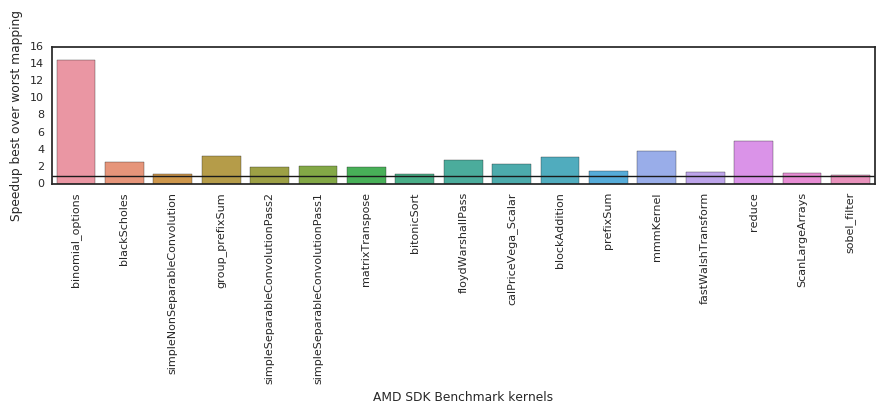

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,F1:transfer/(comp+mem),F2:coalesced/mem,F3:(localmem/mem)*avgws,F4:comp/mem,oracle,runtime,speedup,penalty,runtime_cpu,runtime_gpu
0,amd-app-sdk-3.0-BinomialOption-binomial_options,default,98,8,13,11,2,0,2048,255,18.450450,0.154,215.769231,7.540,GPU,0.200058,14.49,0.07,2.899212,0.200058
1,amd-app-sdk-3.0-BlackScholes-blackScholes,default,220,4,3,0,0,0,3145728,256,14106.403587,0.000,0.000000,73.300,CPU,0.860984,2.57,0.39,0.860984,2.210960
2,amd-app-sdk-3.0-SimpleConvolution-simpleNonSep...,default,9,4,3,0,3,0,4206668,256,350555.666667,1.000,0.000000,3.000,CPU,1.923980,1.20,0.83,1.923980,2.317517
3,amd-app-sdk-3.0-PrefixSum-group_prefixSum,default,36,10,12,8,2,0,4096,2560,85.333333,0.167,1706.666667,3.000,GPU,0.061869,3.33,0.30,0.205866,0.061869
4,amd-app-sdk-3.0-SimpleConvolution-simpleSepara...,default,7,3,3,0,1,0,4206668,256,420666.800000,0.333,0.000000,2.330,CPU,1.158610,1.96,0.51,1.158610,2.265174
5,amd-app-sdk-3.0-SimpleConvolution-simpleSepara...,default,9,3,3,0,1,0,4206668,256,350555.666667,0.333,0.000000,3.000,CPU,1.106050,2.12,0.47,1.106050,2.349008
6,amd-app-sdk-3.0-MatrixTranspose-matrixTranspose,default,42,0,16,8,2,0,32768,256,564.965517,0.125,128.000000,2.620,CPU,0.064724,1.98,0.50,0.064724,0.128298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,amd-app-sdk-3.0-ScanLargeArrays-blockAddition,default,0,1,4,2,2,0,263168,256,65792.000000,0.500,128.000000,0.000,GPU,0.026349,3.20,0.31,0.084302,0.026349
11,amd-app-sdk-3.0-ScanLargeArrays-prefixSum,default,31,3,19,13,3,0,263168,64,5263.360000,0.158,43.789474,1.630,GPU,0.027491,1.51,0.66,0.041449,0.027491


In [90]:
data = None
if can_reproduce_experiments():
    data = pd.read_csv("../data/benchmarks/training.csv")
    
    ax = sns.barplot(x="benchmark", y="speedup", data=data)
    plt.ylabel("Speedup best over worst mapping")
    plt.xlabel("AMD SDK Benchmark kernels")
    plt.axhline(y=1, color="k", lw=1)  # speedup line
    plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
    ax.set_xticklabels([shortbenchmark(x.get_text()) for x in ax.get_xticklabels()])
    viz.finalise(figsize=(9,4))
else:
    print("no new data, skipped", file=sys.stderr)
data

Reproducing experiments on a 1% subset of CLgen kernels:

In [44]:
if can_reproduce_experiments():
    !rm -fv ../data/clgen-10/*.csv
    !cd bin && ./mkdata
else:
    print("platform does not have the requirements to run this experiment", file=sys.stderr)

removed '../data/clgen-10/cpu-errors.csv'
removed '../data/clgen-10/cpu.csv'
removed '../data/clgen-10/gpu-errors.csv'
removed '../data/clgen-10/gpu.csv'
removed '../data/clgen-10/training.csv'
building job list for ../../data/clgen-10/cpu.csv ... 149 jobs
16-11-17 04:45:03 whz5 job [1/150] 0.67% ... cpu 256 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-17 04:45:03 whz5 job [2/150] 1.33% ... cpu 512 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-17 04:45:04 whz5 job [3/150] 2.00% ... cpu 1024 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-17 04:45:04 whz5 job [4/150] 2.67% ... cpu 2048 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-17 04:45:05 whz5 job [5/150] 3.33% ... cpu 4096 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-17 04:45:05 whz5 job [6/150] 4.00% ... cpu 8192 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-17 04:45:05 whz5 job [7/150] 4.67% ... cpu 16384 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-17 04:45:06 whz5 job [8/150] 5.33% ... cpu 65536 019

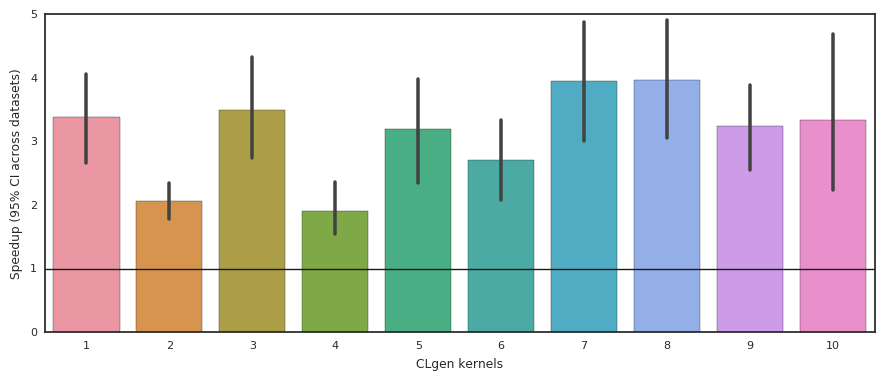

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,speedup,penalty,runtime_cpu,ci_cpu,ci_mean_cpu,runtime_gpu,ci_gpu,ci_mean_gpu,kernel_nlines,kernel_size
0,9e72200ec991cd05cca51fd0eed70b62b8153521.cl-A,4194304,1,2,7,0,6,0,100663296,256,...,3.47,0.29,10.643037,0.167183,0.015708,36.938035,0.042756,0.001158,14,238
1,6e903e54d0cac8224f4aec3e76fb440ab2ded815.cl-A,2048,4,3,6,0,6,0,49152,256,...,1.13,0.89,0.017501,0.004615,0.263699,0.019718,0.001516,0.076884,14,277
2,8b36efab73f8bd181d170a36faf6123dd67eda36.cl-A,65536,2,2,6,0,6,0,1572864,256,...,6.27,0.16,0.087564,0.018601,0.212427,0.548656,0.002541,0.004631,14,226
3,91625993b16566bde25099105b8c142761b6601a.cl-A,256,15,1,2,0,2,0,4096,256,...,2.35,0.43,0.016307,0.006381,0.391304,0.038368,0.000985,0.025672,25,658
4,8b36efab73f8bd181d170a36faf6123dd67eda36.cl-A,262144,2,2,6,0,6,0,6291456,256,...,5.52,0.18,0.382639,0.047126,0.123160,2.111382,0.001111,0.000526,14,226
5,019a0128d0c5fe33678335a7cf7050cad56bbae0.cl-A,512,7,5,16,0,15,0,12288,256,...,1.23,0.81,0.015242,0.011429,0.749836,0.018797,0.002940,0.156408,23,374
6,7ef6954fd966b227d31c66c30de0e36f39f15011.cl-A,4194304,1,2,6,0,5,0,100663296,256,...,3.26,0.31,11.553193,0.143465,0.012418,37.655718,0.136400,0.003622,15,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,1de89a0610d53207c34254a635f13bdb8c7ba6d3.cl-A,65536,5,3,14,0,11,0,2097152,256,...,4.73,0.21,0.153564,0.010067,0.065556,0.726070,0.001473,0.002029,17,323
133,1de89a0610d53207c34254a635f13bdb8c7ba6d3.cl-A,2097152,5,3,14,0,11,0,67108864,256,...,4.19,0.24,5.871338,0.084068,0.014318,24.585651,0.078283,0.003184,17,323


In [91]:
data = None
if can_reproduce_experiments():
    data = pd.read_csv("../data/clgen-10/training.csv")
    
    ax = sns.barplot(x="benchmark", y="speedup", ci=95, data=data)
    plt.ylabel("Speedup (95% CI across datasets)")
    plt.xlabel("CLgen kernels")
    plt.axhline(y=1, color="k", lw=1)  # speedup line
    ax.set_xticklabels(range(1, len(data) + 1))
    viz.finalise(figsize=(9,4))
else:
    print("no new data, skipped", file=sys.stderr)
data

# 8. Experimental Results

We evaluate the effectiveness of our approach on two heterogeneous systems. We
first compare the performance of a state of the art predictive model Grewe et
al. with and without the addition of synthetic benchmarks, then show how the
synthetic benchmarks expose weaknesses in the model’s design and how these can
be addressed to develop a better model. Finally we compare the ability of CLgen
to explore the program feature space against a state of the art program
generator.

## 8.1. Performance Evaluation

Performance data from 1,000 CLgen kernels:

In [46]:
amd_clgen = pd.read_csv("../data/amd-clgen.csv")
amd_clgen

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,speedup,penalty,runtime_cpu,ci_cpu,ci_mean_cpu,runtime_gpu,ci_gpu,ci_mean_gpu,kernel_nlines,kernel_size
0,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,1024,2,2,6,0,5,0,24576,256,...,1.30,0.77,0.059825,0.027666,0.462449,0.046133,0.001591,0.034487,8,191
1,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,1048576,2,2,6,0,5,0,25165824,256,...,1.46,0.68,3.144270,0.301743,0.095966,4.597703,0.821877,0.178758,8,191
2,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,128,2,2,6,0,5,0,3072,128,...,4.41,0.23,0.011245,0.007497,0.666696,0.049600,0.006548,0.132016,8,191
3,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,131072,2,2,6,0,5,0,3145728,256,...,2.12,0.47,0.339146,0.098638,0.290842,0.719252,0.261899,0.364127,8,191
4,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,16384,2,2,6,0,5,0,393216,256,...,1.07,0.94,0.103308,0.002366,0.022902,0.096919,0.001569,0.016189,8,191
5,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,2048,2,2,6,0,5,0,49152,256,...,1.51,0.66,0.072523,0.039571,0.545634,0.047970,0.001733,0.036127,8,191
6,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,2097152,2,2,6,0,5,0,50331648,256,...,1.46,0.69,5.682239,1.689249,0.297286,8.287504,2.788553,0.336477,8,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15912,a670e8ff362eaae5eb70bcbaed23cd018fdaeb7b.cl-A,4096,5,1,7,0,6,0,131072,256,...,5.08,0.20,0.102624,0.153334,1.494134,0.020207,0.000497,0.024595,8,222
15913,a670e8ff362eaae5eb70bcbaed23cd018fdaeb7b.cl-A,4194304,5,1,7,0,6,0,134217728,256,...,1.03,0.97,16.859569,2.117202,0.125579,16.314784,11.227493,0.688179,8,222


In [47]:
nvidia_clgen = pd.read_csv("../data/nvidia-clgen.csv")
nvidia_clgen

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,speedup,penalty,runtime_cpu,ci_cpu,ci_mean_cpu,runtime_gpu,ci_gpu,ci_mean_gpu,kernel_nlines,kernel_size
0,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,1024,2,2,6,0,5,0,24576,256,...,3.47,0.29,0.059825,0.027666,0.462449,0.017248,0.003733,0.216431,8,191
1,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,1048576,2,2,6,0,5,0,25165824,256,...,2.85,0.35,3.144270,0.301743,0.095966,8.950547,0.010129,0.001132,8,191
2,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,128,2,2,6,0,5,0,3072,128,...,1.43,0.70,0.011245,0.007497,0.666696,0.016096,0.003792,0.235586,8,191
3,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,131072,2,2,6,0,5,0,3145728,256,...,3.14,0.32,0.339146,0.098638,0.290842,1.063418,0.000886,0.000833,8,191
4,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,16384,2,2,6,0,5,0,393216,256,...,1.08,0.92,0.103308,0.002366,0.022902,0.111744,0.003750,0.033559,8,191
5,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,2048,2,2,6,0,5,0,49152,256,...,3.77,0.27,0.072523,0.039571,0.545634,0.019219,0.004765,0.247932,8,191
6,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,2097152,2,2,6,0,5,0,50331648,256,...,3.25,0.31,5.682239,1.689249,0.297286,18.494624,0.106484,0.005758,8,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15912,a670e8ff362eaae5eb70bcbaed23cd018fdaeb7b.cl-A,4096,5,1,7,0,6,0,131072,256,...,4.34,0.23,0.102624,0.153334,1.494134,0.023667,0.003586,0.151519,8,222
15913,a670e8ff362eaae5eb70bcbaed23cd018fdaeb7b.cl-A,4194304,5,1,7,0,6,0,134217728,256,...,2.98,0.34,16.859569,2.117202,0.125579,50.267021,0.740593,0.014733,8,222


**Figure 7:** Speedup of programs using *Grewe et al.* predictive model with and without synthetic benchmarks.

Results on AMD:
  #. benchmarks:                   256 kernels, 680 observations
  #. synthetic:                    1000 kernels, 15919 observations

  ZeroR device:                    CPU

  Speedup of Grewe et al.:         1.26 x
  Speedup w. CLgen:                1.57 x


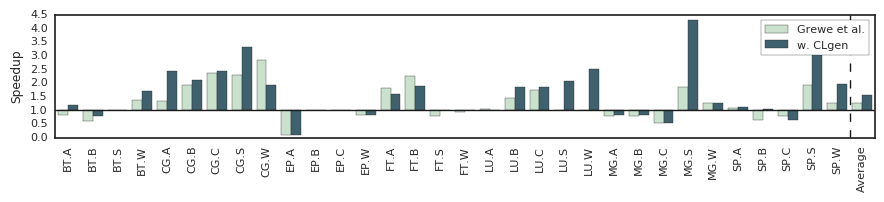

Results on NVIDIA:
  #. benchmarks:                   256 kernels, 680 observations
  #. synthetic:                    1000 kernels, 15919 observations

  ZeroR device:                    GPU

  Speedup of Grewe et al.:         2.50 x
  Speedup w. CLgen:                3.26 x


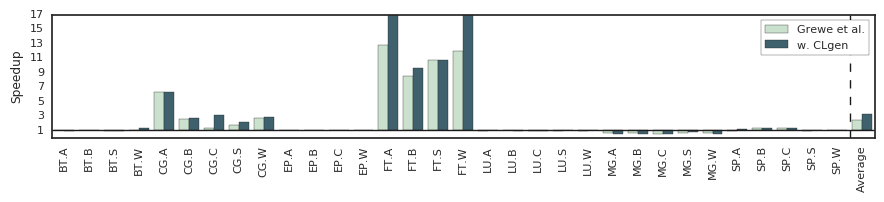

In [48]:
def speedups_with_clgen(platform):
    # datasets: B - benchmarks, S - synthetics, BS - benchmarks + synthetics:
    B = pd.read_csv("../data/{platform}-benchmarks.csv".format(platform=platform))
    B["group"] = ["B"] * len(B)

    S = pd.read_csv("../data/{platform}-clgen.csv".format(platform=platform))
    S["group"] = ["S"] * len(S)

    BS = pd.concat((B, S))

    # find the ZeroR. This is the device which is most frequently optimal
    Bmask = B[B["benchmark"].str.contains("npb-3.3-")]
    zeror = Counter(Bmask["oracle"]).most_common(1)[0][0]
    zeror_runtime = "runtime_" + zeror.lower()

    # get the names of the benchmarks, in the form: $suite-$version-$benchmark
    benchmark_names = sorted(set([
        re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)-", b).group(1)
        for b in B["benchmark"] if b.startswith("npb-")
    ]))

    B_out, BS_out = [], []
    for benchmark in benchmark_names:
        clf = cgo13.model()
        features = get_cgo13_features
        # cross validate on baseline
        B_out += cgo13.leave_one_benchmark_out(clf, features, B, benchmark)
        # reset model
        clf = cgo13.model()
        # repeate cross-validation with synthetic kernels
        BS_out += cgo13.leave_one_benchmark_out(clf, features, BS, benchmark)

    # create results frame
    R_out = []
    for b, bs in zip(B_out, BS_out):
        # get runtimes of device using predicted device
        b_p_runtime = b["runtime_" + b["p"].lower()]
        bs_p_runtime = bs["runtime_" + bs["p"].lower()]

        # speedup is the ratio of runtime using the predicted device
        # over runtime using ZeroR device
        b["p_speedup"] = b_p_runtime / b[zeror_runtime]
        bs["p_speedup"] = bs_p_runtime / bs[zeror_runtime]

        # get the group label, in the form $benchmark.$dataset
        group = re.sub(r"[^-]+-[0-9\.]+-([^-]+)-.+", r"\1",
                       b["benchmark"]) + "." + b["dataset"]
        b["group"] = group
        bs["group"] = group

        # set the training data type
        b["training"] = "Grewe et al."
        bs["training"] = "w. CLgen"

        R_out.append(b)
        R_out.append(bs)

    R = pd.DataFrame(R_out)

    b_mask = R["training"] == "Grewe et al."
    bs_mask = R["training"] == "w. CLgen"

    B_speedup = labmath.mean(R[b_mask].groupby(["group"])["p_speedup"].mean())
    BS_speedup = labmath.mean(R[bs_mask].groupby(["group"])["p_speedup"].mean())

    print("Results on {}:".format(platform.upper()))
    print("  #. benchmarks:                  ",
          len(set(B["benchmark"])), "kernels,", len(B), "observations")
    print("  #. synthetic:                   ",
          len(set(S["benchmark"])), "kernels,", len(S), "observations")
    print()
    print("  ZeroR device:                    {}".format(zeror))
    print()
    print("  Speedup of Grewe et al.:         {:.2f} x".format(B_speedup))
    print("  Speedup w. CLgen:                {:.2f} x".format(BS_speedup))

    R = R.append({  # average bars
        "group": "Average",
        "p_speedup": B_speedup,
        "training": "Grewe et al."
    }, ignore_index=True)
    R = R.append({
        "group": "Average",
        "p_speedup": BS_speedup,
        "training": "w. CLgen"
    }, ignore_index=True)

    R["p_speedup"] -= 1  # negative offset so that bars start at 1

    # colors
    palette = sns.cubehelix_palette(len(set(R["training"])),
                                    rot=-.4, light=.85, dark=.35)

    ax = sns.barplot(
        x="group", y="p_speedup", data=R, ci=None, hue="training",
        palette=palette)
    plt.ylabel("Speedup")
    plt.xlabel("")

    plt.axhline(y=0, color="k", lw=1)  # speedup line
    plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

    ax.get_legend().set_title("")  # no legend title
    plt.legend(loc='upper right')
    ax.get_legend().draw_frame(True)

    # plot shape and size
    figsize = (9, 2.2)
    if platform == "nvidia":
        typecast = int; plt.ylim(-1, 16)
    else:
        typecast = float

    # counter negative offset:
    ax.set_yticklabels([typecast(i) + 1 for i in ax.get_yticks()])

    plt.setp(ax.get_xticklabels(), rotation=90)

    viz.finalise(figsize=figsize, tight=True)

speedups_with_clgen("amd")
speedups_with_clgen("nvidia")

Speedups of the *Grewe et al. *predictive model over the NAS Parallel Benchmark
suite with and without the addition of synthesized benchmarks for training.
Speedups are calculated relative to the best single-device mapping for each
experimental platform, which is CPU-only for AMD and GPU-only for NVIDIA. The
fine grained coverage of the feature space which synthetic benchmarks provide
improves performance dramatically for the NAS benchmarks. Across both systems,
we achieve an average speedup of 2.42x with the addition of synthetic
benchmarks, with prediction improvements over the baseline for 62.5% of
benchmarks on AMD and 53.1% on NVIDIA.

The strongest performance improvements are on NVIDIA with the `FT` benchmark, a
benchmark which suffers greatly under a single-device mapping. However, the
performance on AMD for the same benchmark slightly degrades after adding the
synthetic benchmarks, which we address in the next section.

Repeat this experiment on the small subset of data we produced earlier:

Results:
  #. benchmarks:                   17 kernels, 17 observations
  #. synthetic:                    10 kernels, 139 observations

  ZeroR device:                    CPU

  Speedup of Grewe et al.:         0.98 x
  Speedup w. CLgen:                1.25 x


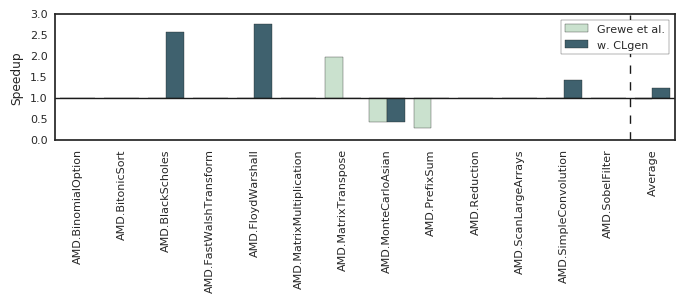

In [87]:
if can_reproduce_experiments():
    # datasets: B - benchmarks, S - synthetics, BS - benchmarks + synthetics:
    B = pd.read_csv("../data/benchmarks/training.csv")
    B["group"] = ["B"] * len(B)

    S = pd.read_csv("../data/clgen-10/training.csv")
    S["group"] = ["S"] * len(S)

    BS = pd.concat((B, S))

    # find the ZeroR. This is the device which is most frequently optimal
    zeror = Counter(B["oracle"]).most_common(1)[0][0]
    zeror_runtime = "runtime_" + zeror.lower()

    # get the names of the benchmarks, in the form: $suite-$version-$benchmark
    benchmark_names = sorted(set([
        re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)-", b).group(1)
        for b in B["benchmark"]
    ]))

    B_out, BS_out = [], []
    for benchmark in benchmark_names:
        clf = cgo13.model()
        features = get_cgo13_features
        # cross validate on baseline
        B_out += cgo13.leave_one_benchmark_out(clf, features, B, benchmark)
        # reset model
        clf = cgo13.model()
        # repeate cross-validation with synthetic kernels
        BS_out += cgo13.leave_one_benchmark_out(clf, features, BS, benchmark)

    # create results frame
    R_out = []
    for b, bs in zip(B_out, BS_out):
        # get runtimes of device using predicted device
        b_p_runtime = b["runtime_" + b["p"].lower()]
        bs_p_runtime = bs["runtime_" + bs["p"].lower()]

        # speedup is the ratio of runtime using the predicted device
        # over runtime using ZeroR device
        b["p_speedup"] = b_p_runtime / b[zeror_runtime]
        bs["p_speedup"] = bs_p_runtime / bs[zeror_runtime]

        # get the group label, in the form $benchmark.$dataset
        group = escape_benchmark_name(b["benchmark"])
        b["group"] = group
        bs["group"] = group

        # set the training data type
        b["training"] = "Grewe et al."
        bs["training"] = "w. CLgen"

        R_out.append(b)
        R_out.append(bs)

    R = pd.DataFrame(R_out)
    b_mask = R["training"] == "Grewe et al."
    bs_mask = R["training"] == "w. CLgen"

    B_speedup = labmath.mean(R[b_mask].groupby(["group"])["p_speedup"].mean())
    BS_speedup = labmath.mean(R[bs_mask].groupby(["group"])["p_speedup"].mean())

    print("Results:")
    print("  #. benchmarks:                  ",
          len(set(B["benchmark"])), "kernels,", len(B), "observations")
    print("  #. synthetic:                   ",
          len(set(S["benchmark"])), "kernels,", len(S), "observations")
    print()
    print("  ZeroR device:                    {}".format(zeror))
    print()
    print("  Speedup of Grewe et al.:         {:.2f} x".format(B_speedup))
    print("  Speedup w. CLgen:                {:.2f} x".format(BS_speedup))

    R = R.append({  # average bars
        "group": "Average",
        "p_speedup": B_speedup,
        "training": "Grewe et al."
    }, ignore_index=True)
    R = R.append({
        "group": "Average",
        "p_speedup": BS_speedup,
        "training": "w. CLgen"
    }, ignore_index=True)

    R["p_speedup"] -= 1  # negative offset so that bars start at 1

    # colors
    palette = sns.cubehelix_palette(len(set(R["training"])),
                                    rot=-.4, light=.85, dark=.35)

    ax = sns.barplot(
        x="group", y="p_speedup", data=R, ci=None, hue="training",
        palette=palette)
    plt.ylabel("Speedup")
    plt.xlabel("")

    plt.axhline(y=0, color="k", lw=1)  # speedup line
    plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

    ax.get_legend().set_title("")  # no legend title
    plt.legend(loc='upper right')
    ax.get_legend().draw_frame(True)

    # plot shape and size
    figsize = (7, 3.2)
    typecast = float

    # counter negative offset:
    ax.set_yticklabels([typecast(i) + 1 for i in ax.get_yticks()])

    plt.setp(ax.get_xticklabels(), rotation=90)

    viz.finalise(figsize=figsize, tight=True)
else:
    print("no new data, skipped", file=sys.stderr)

## 8.3. Extending the Predictive Model

Feature designers are bound to select as features only properties which are
significant for the sparse benchmarks they test on, which can limit a model’s
ability to generalize over a wider range of programs. We found this to be the
case with the *Grewe et al.* model. The addition of automatically generated
programs exposed two distinct cases where the model failed to generalize as a
result of overspecializing to the NPB suite.

The first case is that `F3` is sparse on many programs. This a result of the NPB
implementation’s heavy exploitation of local memory buffers and the method by
which they combined features (we speculate this was a necessary dimensionality
reduction in the presence of sparse training programs). To counter this we
extended the model to use the raw features in addition to the combined features.

Distribution of feature values:

ratio zero values feature 1: 0.006 %
ratio zero values feature 2: 0.804 %
ratio zero values feature 3: 99.497 %
ratio zero values feature 4: 24.757 %


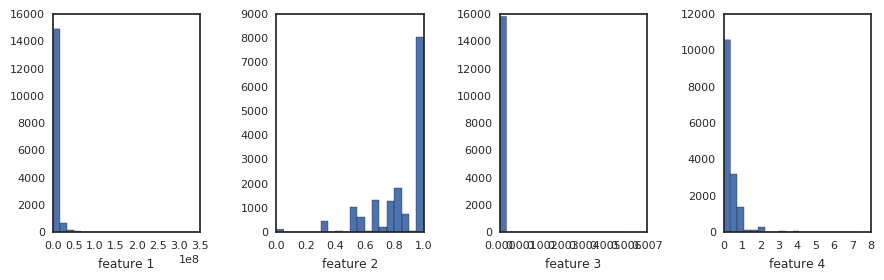

In [50]:
F = [  # features
    amd_clgen["F1:transfer/(comp+mem)"],
    amd_clgen["F2:coalesced/mem"],
    amd_clgen["F3:(localmem/mem)*avgws"],
    amd_clgen["F4:comp/mem"]
]
nres = len(F[0])

plt.subplots(1, 4)
for i in range(len(F)):
    plt.subplot(1, 4, i + 1)
    plt.hist(F[i], bins=20)
    plt.xlim(0,)
    plt.xlabel("feature " + str(i + 1))
    nzeros = sum([1 for x in F[i] if x == 0])
    print("ratio zero values feature {}: {:.3f} %".format(i + 1, (nzeros / nres) * 100))

viz.finalise(figsize=(9,3))

The second case is that some of our generated programs had identical feature
values as in the benchmark set, but had different *behavior* (i.e. optimal
mappings):

In [51]:
def same_features_different_behaviour(a, b, getfeatures):
    """returns true if features match but oracle device differs"""
    af, bf = getfeatures(a), getfeatures(b)
    ab, bb = a["oracle"], b["oracle"]
    return ab != bb and np.array_equal(af, bf)

print("Number of instances where CLgen kernels have identical features to benchmarks but different behaviour:")
matches, i, imax = defaultdict(int), 0, len(amd_benchmarks)
for a in amd_benchmarks.to_dict('records'):
    i += 1
    print("\r", i, "of", imax, a["benchmark"], end="")
    for b in amd_clgen.to_dict('records'):
        if same_features_different_behaviour(a, b, cgo13.static_features):
            matches[a["benchmark"]] += 1

print("\r" + clgen.format_json(matches))

Number of instances where CLgen kernels have identical features to benchmarks but different behaviour:
{
  "npb-3.3-CG-conj_grad_0": 1380,
  "npb-3.3-CG-init_mem_0": 849,
  "npb-3.3-CG-init_mem_1": 849,
  "npb-3.3-CG-main_0": 126,
  "npb-3.3-CG-main_1": 630,
  "npb-3.3-CG-main_2": 395,
  "npb-3.3-FT-init_ui": 928,
  "nvidia-4.2-MatVecMul-MatVecMulUncoalesced0": 8,
  "nvidia-4.2-MatVecMul-MatVecMulUncoalesced1": 8,
  "nvidia-4.2-VectorAdd-VectorAdd": 370,
  "parboil-0.2-spmv-A": 114,
  "polybench-gpu-1.0-atax-atax_kernel1": 7,
  "polybench-gpu-1.0-atax-atax_kernel2": 7,
  "polybench-gpu-1.0-bicg-bicgKernel1": 110,
  "polybench-gpu-1.0-bicg-bicgKernel2": 110,
  "polybench-gpu-1.0-mvt-mvt_kernel1": 7,
  "polybench-gpu-1.0-mvt-mvt_kernel2": 7,
  "rodinia-3.1-bfs-BFS_2": 28,
  "rodinia-3.1-cfd-initialize_variables": 8,
  "rodinia-3.1-cfd-memset_kernel": 198,
  "rodinia-3.1-particlefilter-find_index_kernel": 46,
  "rodinia-3.1-particlefilter-sum_kernel": 250,
  "rodinia-3.1-streamcluster-mem

We found this to be caused by the lack of discriminatory features for branching,
since the NPB programs are implemented in a manner which aggressively minimized
branching. To counter this we extended the predictive model with an additional
feature with a static count of branching operations in a kernel.

Speedups of our extended model across all seven of the benchmark suites used in Section 2:

**Figure 8:** Speedups of predictions using our extended model over *Grewe et al.* on both experimental platforms.

analyzing 71 shoc-1.1.5-Triad
  #. benchmarks:           256 kernels, 1360 observations
  #. synthetic:            1000 kernels, 31838 observations

  Speedup on AMD:          3.56 x
  Speedup on NVIDIA:       5.04 x


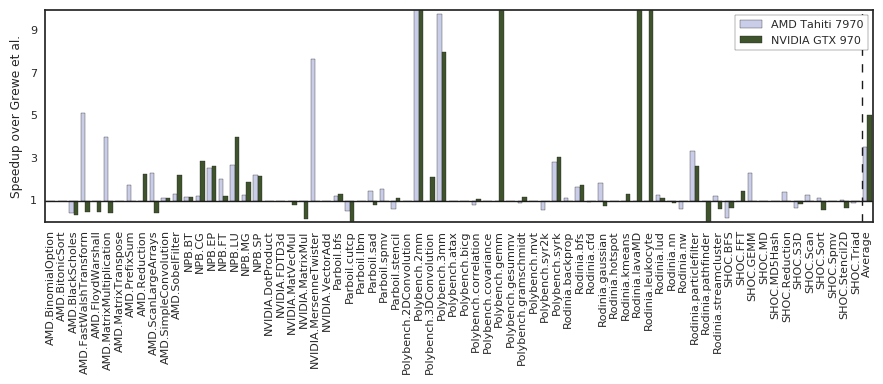

In [52]:
def compare_clfs(clf1, get_features1, clf2, get_features2, D1, D2, benchmark):
    """cross-validate across all benchmarks using CGO13 model and our own, with
    and without synthetic benchmarks. Report per-platform speedup of our model
    over CGO13"""
    test1_mask = D1["benchmark"].str.contains(r"^" + benchmark)
    test2_mask = D2["benchmark"].str.contains(r"^" + benchmark)
    assert(len(D1[test1_mask]) == len(D2[test2_mask]))

    # create data masks. For training we exclude all results from benchmark
    train1_mask = ~test1_mask
    train2_mask = ~test2_mask

    # create training and testing data
    X1_train = get_features1(D1.loc[train1_mask])
    X2_train = get_features2(D2.loc[train2_mask])
    y1_train = cgo13.getlabels(D1[train1_mask])
    y2_train = cgo13.getlabels(D2[train2_mask])

    D1_test = D1[test1_mask]
    D2_test = D2[test2_mask]
    X1_test = get_features1(D1.loc[test1_mask])
    X2_test = get_features2(D2.loc[test2_mask])
    y1_test = cgo13.getlabels(D1_test)
    y2_test = cgo13.getlabels(D2_test)

    clf1.fit(X1_train, y1_train)  # train classifiers
    clf2.fit(X2_train, y2_train)

    predicted1 = clf1.predict(X1_test)  # make predictions
    predicted2 = clf2.predict(X2_test)

    D_out = []
    for d, y, p1, p2 in zip(D1_test.to_dict('records'), y1_test,
                            predicted1, predicted2):
        d["p1"], d["p2"] = p1, p2
        D_out.append(d)

    return D_out  # return a list of dicts


aB = pd.read_csv("../data/amd-benchmarks.csv")
aB["synthetic"] = np.zeros(len(aB))
bB = pd.read_csv("../data/nvidia-benchmarks.csv")
bB["synthetic"] = np.zeros(len(bB))
B = pd.concat((aB, bB))

aS = pd.read_csv("../data/amd-clgen.csv")
aS["synthetic"] = np.ones(len(aS))
bS = pd.read_csv("../data/nvidia-clgen.csv")
bS["synthetic"] = np.ones(len(bS))
S = pd.concat((aS, bS))

aBS = pd.concat((aB, aS))
bBS = pd.concat((bB, bS))
BS = pd.concat((B, S))

assert(len(B) == len(aB) + len(bB))  # sanity checks
assert(len(S) == len(aS) + len(bS))
assert(len(BS) == len(aBS) + len(bBS))

# get benchmark names: <suite>-<benchmark>
benchmark_names = sorted(set([
    re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)", b).group(1)
    for b in B["benchmark"]
]))

# perform cross-validation
B_out = []
for i, benchmark in enumerate(benchmark_names):
    print("\ranalyzing", i + 1, benchmark, end="")
    cgo13_clf, our_clf = cgo13.model(), get_our_model()
    cgo13_features, our_features = get_cgo13_features, get_our_features

    # cross validate on Grewe et al. and our model
    tmp = compare_clfs(cgo13_clf, cgo13_features, our_clf, our_features,
                       aBS, aBS, benchmark)
    for d in tmp: d["platform"] = "AMD Tahiti 7970"
    B_out += tmp

    # reset models
    cgo13_clf, our_clf = cgo13.model(), get_our_model()

    # same as before, on other platform:
    tmp = compare_clfs(cgo13_clf, cgo13_features, our_clf, our_features,
                       bBS, bBS, benchmark)
    for d in tmp: d["platform"] = "NVIDIA GTX 970"
    B_out += tmp
print()

# create results frame
R_out = []
# get runtimes of device using predicted device
for b in B_out:
    p1_runtime = b["runtime_" + b["p1"].lower()]
    p2_runtime = b["runtime_" + b["p2"].lower()]

    # speedup is the ratio of runtime using our predicted device
    # over runtime using CGO13 predicted device.
    b["p_speedup"] = p2_runtime / p1_runtime

    # get the benchmark name
    b["group"] = escape_benchmark_name(b["benchmark"])

    R_out.append(b)
R = pd.DataFrame(R_out)

improved = R[R["p_speedup"] > 1]

Amask = R["platform"] == "AMD Tahiti 7970"
Bmask = R["platform"] == "NVIDIA GTX 970"
a = R[Amask]
b = R[Bmask]

a_speedups = a.groupby(["group"])["p_speedup"].mean()
b_speedups = b.groupby(["group"])["p_speedup"].mean()

a_speedup = labmath.mean(a_speedups)
b_speedup = labmath.mean(b_speedups)

assert(len(R) == len(a) + len(b))  # sanity-check

print("  #. benchmarks:          ",
      len(set(B["benchmark"])), "kernels,", len(B), "observations")
print("  #. synthetic:           ",
      len(set(S["benchmark"])), "kernels,", len(S), "observations")
print()
print("  Speedup on AMD:          {:.2f} x".format(a_speedup))
print("  Speedup on NVIDIA:       {:.2f} x".format(b_speedup))

palette = sns.cubehelix_palette(
    len(set(R["platform"])), start=4, rot=.8, light=.8, dark=.3)

R = R.append({  # average bars
    "group": "Average",
    "p_speedup": a_speedup,
    "platform": "AMD Tahiti 7970"
}, ignore_index=True)
R = R.append({
    "group": "Average",
    "p_speedup": b_speedup,
    "platform": "NVIDIA GTX 970"
}, ignore_index=True)

R["p_speedup"] -= 1  # negative offset so that bars start at 1

ax = sns.barplot(x="group", y="p_speedup", hue="platform", data=R,
                 palette=palette, ci=None)

plt.ylabel("Speedup over Grewe et al."); plt.xlabel("")

plt.axhline(y=0, color="k", lw=1)
plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
plt.ylim(-1, 9)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
ax.get_legend().set_title("")  # legend
plt.legend(loc='upper right')

# counter negative offset
ax.set_yticklabels([int(i) + 1 for i in ax.get_yticks()])

ax.get_legend().draw_frame(True)

viz.finalise(figsize=(9, 4), tight=True)

Model performance, even on this tenfold increase of benchmarks, is good. There
are three benchmarks on which the model performs poorly: `gemmv`, `hotspot`, and
`pathfinder`. Each of those programs make heavy use of loops, which we believe
the static code features of the model fail to capture. This could be addressed
by extracting dynamic instruction counts using profiling, but we considered this
beyond the scope of our work. It is not our goal to perfect the predictive
model, but to show the performance improvements associated with training on
synthetic programs. To this extent, we are successful, achieving average
speedups of $3.56\times$ on AMD and $5.04\times$ on NVIDIA across a very large
test set.

Repeat this experiment using the small subset of experimental data we produced earlier:

analyzing 13 amd-app-sdk-3.0-SobelFilter
  #. benchmarks:           17 kernels, 17 observations
  #. synthetic:            10 kernels, 139 observations

  Speedup:                 1.01 x


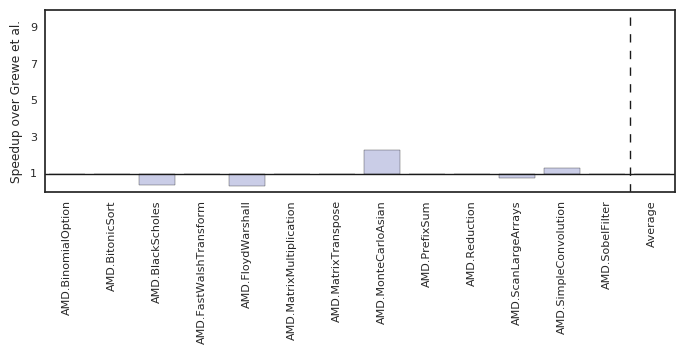

In [88]:
def compare_clfs(clf1, get_features1, clf2, get_features2, D1, D2, benchmark):
    """cross-validate across all benchmarks using CGO13 model and our own, with
    and without synthetic benchmarks. Report per-platform speedup of our model
    over CGO13"""
    test1_mask = D1["benchmark"].str.contains(r"^" + benchmark)
    test2_mask = D2["benchmark"].str.contains(r"^" + benchmark)
    assert(len(D1[test1_mask]) == len(D2[test2_mask]))

    # create data masks. For training we exclude all results from benchmark
    train1_mask = ~test1_mask
    train2_mask = ~test2_mask

    # create training and testing data
    X1_train = get_features1(D1.loc[train1_mask])
    X2_train = get_features2(D2.loc[train2_mask])
    y1_train = cgo13.getlabels(D1[train1_mask])
    y2_train = cgo13.getlabels(D2[train2_mask])

    D1_test = D1[test1_mask]
    D2_test = D2[test2_mask]
    X1_test = get_features1(D1.loc[test1_mask])
    X2_test = get_features2(D2.loc[test2_mask])
    y1_test = cgo13.getlabels(D1_test)
    y2_test = cgo13.getlabels(D2_test)

    clf1.fit(X1_train, y1_train)  # train classifiers
    clf2.fit(X2_train, y2_train)

    predicted1 = clf1.predict(X1_test)  # make predictions
    predicted2 = clf2.predict(X2_test)

    D_out = []
    for d, y, p1, p2 in zip(D1_test.to_dict('records'), y1_test,
                            predicted1, predicted2):
        d["p1"], d["p2"] = p1, p2
        D_out.append(d)

    return D_out  # return a list of dicts

if can_reproduce_experiments():
    B = pd.read_csv("../data/benchmarks/training.csv")
    B["synthetic"] = np.zeros(len(B))

    S = pd.read_csv("../data/clgen-10/training.csv")
    S["synthetic"] = np.ones(len(S))

    BS = pd.concat((B, S))

    assert(len(BS) == len(B) + len(S))

    # get benchmark names: <suite>-<benchmark>
    benchmark_names = sorted(set([
        re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)", b).group(1)
        for b in B["benchmark"]
    ]))

    # perform cross-validation
    B_out = []
    for i, benchmark in enumerate(benchmark_names):
        print("\ranalyzing", i + 1, benchmark, end="")
        cgo13_clf, our_clf = cgo13.model(), get_our_model()
        cgo13_features, our_features = get_cgo13_features, get_our_features

        # cross validate on Grewe et al. and our model
        tmp = compare_clfs(cgo13_clf, cgo13_features, our_clf, our_features,
                           BS, BS, benchmark)
        B_out += tmp
    print()

    # create results frame
    R_out = []
    # get runtimes of device using predicted device
    for b in B_out:
        p1_runtime = b["runtime_" + b["p1"].lower()]
        p2_runtime = b["runtime_" + b["p2"].lower()]

        # speedup is the ratio of runtime using our predicted device
        # over runtime using CGO13 predicted device.
        b["p_speedup"] = p2_runtime / p1_runtime

        # get the benchmark name
        b["group"] = escape_benchmark_name(b["benchmark"])

        R_out.append(b)
    R = pd.DataFrame(R_out)

    improved = R[R["p_speedup"] > 1]

    speedups = R.groupby(["group"])["p_speedup"].mean()
    speedup = labmath.mean(speedups)

    print("  #. benchmarks:          ",
          len(set(B["benchmark"])), "kernels,", len(B), "observations")
    print("  #. synthetic:           ",
          len(set(S["benchmark"])), "kernels,", len(S), "observations")
    print()
    print("  Speedup:                 {:.2f} x".format(speedup))

    palette = sns.cubehelix_palette(1, start=4, rot=.8, light=.8, dark=.3)

    R = R.append({  # average bar
        "group": "Average",
        "p_speedup": speedup
    }, ignore_index=True)

    R["p_speedup"] -= 1  # negative offset so that bars start at 1

    ax = sns.barplot(x="group", y="p_speedup", data=R,
                     palette=palette, ci=None)

    plt.ylabel("Speedup over Grewe et al."); plt.xlabel("")

    plt.axhline(y=0, color="k", lw=1)
    plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
    plt.ylim(-1, 9)
    plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks

    # counter negative offset
    ax.set_yticklabels([int(i) + 1 for i in ax.get_yticks()])

    viz.finalise(figsize=(7, 3.7), tight=True)
else:
    print("no new data, skipped", file=sys.stderr)

## 8.3. Comparison of Source Features

As demonstrated in Section 2, the predictive quality of a model for a given
point in the feature space is improved with the addition of observations from
neighboring points. By producing thousands of artificial programs modeled on the
structure real OpenCL programs, CLgen is able to consistently and automatically
generate programs which are close in the feature space to the benchmarks which
we are testing on.

To quantify this effect we use the static code features, plus the branching
feature discussed in the previous subsection, to measure the number of CLgen
kernels generated with the same feature values as those of the benchmarks we
examined in the previous subsections. We examine only static code features to
allow comparison with the GitHub kernels for which we have no automated method
to execute them and extract runtime features, and CLSmith generated programs.

Plotting the number of matches as a function of the number of kernels:

**Figure 9:** The number of kernels from GitHub, CLSmith, and CLgen with static code features matching the benchmarks. CLgen generates kernels that are closer in the feature space than CLSmith, and can continue to do so long after we have exhausted the extent of the GitHub dataset.

#. GitHub kernels  6500
#. CLSmith kernels 10000
#. CLgen kernels   10000
 CLgen 21 of 21

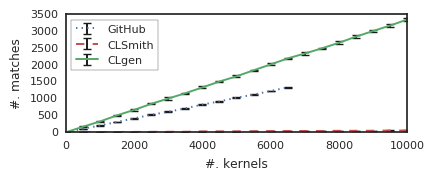

In [54]:
def uniq_benchmarks(g):
    """return set of unique benchmarks, removes duplicates"""
    uniq, out = set(), []
    for row in g.to_dict('records'):
        key = (row['benchmark'])
        if key not in uniq:
            out.append(row)
            uniq.add(key)
    return pd.DataFrame(out)

np.random.seed(204)

# load datasets
CLgen = pd.read_csv("../data/clgen-features.csv")
GitHub = pd.read_csv("../data/github-features.csv")
CLSmith = pd.read_csv("../data/clsmith-features.csv")

# extract features
Benchmarks_features = cgo13.get_static_features(uniq_benchmarks(amd_benchmarks))
CLgen_features = cgo13.get_static_features(CLgen)
GitHub_features = cgo13.get_static_features(GitHub)
CLSmith_features = cgo13.get_static_features(CLSmith)

stepMin, stepMax = 0, 10000
linStepSize = int((stepMax - stepMin) / 20)
closeness_threshold = 0

steps = np.array(list(range(stepMin, stepMax + linStepSize, linStepSize)),
                 dtype=np.int32)
steps[0] = max(steps[0], 1)

GitHubSteps = [n for n in steps if n <= len(GitHub_features)]
CLSmithSteps = [n for n in steps if n <= len(CLSmith_features)]
CLgenSteps = [n for n in steps if n <= len(CLgen_features)]

numGitHubSteps = len(GitHubSteps)
numCLSmithSteps = len(CLSmithSteps)
numCLgenSteps = len(CLgenSteps)

print("#. GitHub kernels ", GitHubSteps[-1])
print("#. CLSmith kernels", CLSmithSteps[-1])
print("#. CLgen kernels  ", CLgenSteps[-1])

datasets = [
    {
        "name": "GitHub",
        "color": "b",
        "linestyle": ":",
        "steps": GitHubSteps,
        "static_features": GitHub_features,
        "distances": np.zeros(numGitHubSteps, dtype=float),
        "errors": np.zeros(numGitHubSteps, dtype=float)
    },
    {
        "name": "CLSmith",
        "color": "r",
        "linestyle": "--",
        "steps": CLSmithSteps,
        "static_features": CLSmith_features,
        "distances": np.zeros(numCLSmithSteps, dtype=float),
        "errors": np.zeros(numCLSmithSteps, dtype=float)
    },
    {
        "name": "CLgen",
        "color": "g",
        "linestyle": "-",
        "steps": CLgenSteps,
        "static_features": CLgen_features,
        "distances": np.zeros(numCLgenSteps, dtype=float),
        "errors": np.zeros(numCLgenSteps, dtype=float)
    },
]

numIterations = 10  # repeat experiment N times
for dataset in datasets:
    for i, n in enumerate(dataset["steps"]):
        numSteps = len(dataset["steps"])
        print("\r", dataset["name"], i + 1, "of", numSteps, end="")
        r = np.zeros(numIterations, dtype=float)
        for j in range(numIterations):
            np.random.shuffle(dataset["static_features"])
            distances = get_nearest_neighbour_distance(
                dataset["static_features"][:n], Benchmarks_features)
            r[j] = sum([1 if d <= closeness_threshold else 0 for d in distances])
        dataset["distances"][i] = np.mean(r)
        dataset["errors"][i] = np.std(r)
    plt.errorbar(dataset["steps"], dataset["distances"],
                 yerr=dataset["errors"], c=dataset["color"],
                 linestyle=dataset["linestyle"],
                 label=dataset["name"], ecolor="k", capthick=1)
ax = plt.gca()

plt.legend(loc='upper left')
ax.get_legend().set_title("")
ax.get_legend().draw_frame(True)

plt.xlim(stepMin, stepMax)
plt.ylim(0,)
plt.xlabel("#. kernels"); plt.ylabel("#. matches")

viz.finalise(figsize=(4.5, 2))

Out of 10,000 unique CLgen kernels, more than a third have static feature values
matching those of the benchmarks, providing on average 14 CLgen kernels for each
benchmark. This confirms our original intuition: CLgen kernels, by emulating the
way real humans write OpenCL programs, are concentrated in the same area of the
feature space as real programs. Moreover, the number of CLgen kernels we
generate is unbounded, allowing us to continually refine the exploration of the
feature space, while the number of kernels available on GitHub is finite.
CLSmith rarely produces code similar to real-world OpenCL programs, with only
0.53% of the generated kernels have matching feature values with benchmark
kernels. We conclude that the unique contribution of CLgen is its ability to
generate many thousands of programs *that are appropriate for predictive
modeling*.

# 9. Related Work

See the PDF version of this paper.

# 10. Conclusion

The quality of predictive models is bound by the quantity and quality of
programs used for training, yet there is typically only a few dozen common
benchmarks available for experiments. We present a novel tool which is the first
of it’s kind — an entirely probabilistic program generator capable of generating
an unbounded number of human like programs. Our approach applies deep learning
over a huge corpus of publicly available code from GitHub to automatically infer
the semantics and practical usage of a programming language. Our tool generates
programs which to trained eyes are indistinguishable from hand-written code. We
tested our approach using a state of the art predictive model, improving its
performance by a factor of 1.27x. We found that synthetic benchmarks exposed
weaknesses in the feature set which, when corrected, further improved the
performance by 2.66x. In future work we will extend CLgen to synthesize
benchmarks in multiple programming languages, and investigate methods for
performing an automatic directed search of the program space.

In [55]:
print("Evaluation complete.")

Evaluation complete.
